This notebook reproduces all figures from Klimek et al EPJE 2025.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from correlation_functions_expos import *
# from mfpt_gammaq_md import compute_friction_profile, compute_mfpt_from_gammaq

import matplotlib.gridspec as gridspec
import mpltex
import matplotlib.transforms as mtransforms

# from PIL import Image

from scipy.special import gamma as gamma_func
# from scipy.optimize import minimize


alphabet_capital = list(map(chr, range(65, 91)))
alphabet = list(map(chr, range(97, 123)))

def int_kernel_exp(t, amps, taus):
    integral = 0
    for i in range(len(amps)):
        integral += amps[i] * taus[i] * (1 - np.exp(-t/taus[i]))
    return integral

def kernel_exp(t, c, d, n, tau0, g0):
    kern = np.zeros(len(t))
    gammai = d**np.arange(n, dtype=float)
    gammai /= np.sum(gammai)
    for ind_term in range(n):
        kern += gammai[ind_term] / (tau0 * c**ind_term) * np.exp(-t/(tau0 * c**ind_term))
    return g0 * kern

def kern_pow(t, alpha, g0):
    return g0  / (t**(alpha) * gamma_func(1 - alpha))

def kern_pow_2(t, alpha):
    return 1 / t**(alpha)

def sigma_kerns(arr, t, alpha, c, n, tau0):
    sigma = kernel_exp(t, c, arr[0], n, tau0, arr[1]) - kern_pow(t, alpha, 1)
    return sigma

def sigma_kerns_alpha(arr, t, c, d, n, tau0):
    sigma = (np.log(kernel_exp(t, c, d, n, tau0, arr[1])) - np.log(kern_pow(t, arr[0], 1)))
    return sigma

def multiexp_plot(t, gammas, taus):
    # return sum of n=len(gammas) exponentials memory kernel
    multiexp = 0
    for n in range(len(gammas)):
        multiexp += np.exp(-t/taus[n]) * gammas[n] / taus[n]
    return multiexp

def log_smoothing(data, n): #pref, log_fac):
    # function tested by plotting noisy data and smoothed data
    # n is the length of the data after smoothing
    log_inds = np.unique(np.int64((np.logspace(0, np.log10(len(data)), n))))
    mid_points = np.int64((log_inds + np.append(0, log_inds[:-1])) / 2) # indices at which smooth function values are evaluated
    smooth_data = np.zeros(len(log_inds))
    ind_before = 0
    for i in range(len(log_inds)):
        smooth_data[i] = np.sum(data[ind_before : log_inds[i]]) / (log_inds[i] - ind_before) #average over exponentially increasing window
        ind_before = log_inds[i]

    return mid_points, smooth_data

def load_dw_msd_alpha(c, d, U, n, sc, dt, taum, nsteps='1e8', av=1009):
    Ustr = str(int(U))
    if U == 0.5:
        Ustr = '05'
    try:
        msd = np.load('./msd/msd_av1009c' + str(int(c)) + '_d' + str(int(d)) + '_U' + Ustr + '_n' + str(int(n)) + '_sc' + str(int(sc)) +
                        '_dw_bins100_r1.0_l-1.0_tm' + f'{taum:e}'[:3] + f'{taum:e}'[-3:] + '_n' + nsteps + '_dt' + str(dt) + '.npy')[:, :-5]
    except:
        msd = np.load('./msd/msd_av' + str(int(av)) + 'c' + str(int(c)) + '_d' + str(int(d)) + '_U' + Ustr + '_n' + str(int(n)) + '_sc' + str(int(sc)) +
                        '_dw_bins100_r1.0_l-1.0_tm' + str(round(taum, 1)) + '_n' + nsteps + '_dt' + str(dt) + '.npy')[:, :-5]

    alpha = np.diff(np.log(msd[0,:]))/np.diff(np.log(msd[1,:]))

    return msd, alpha

def plot_n3_msd(ax, dlist, c, tau_scaling=1, tau_m=1, indicate=False):
    taud = 1
    taum = tau_m * taud
    L = 1
    kT = 1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud

    for d in dlist:
        str_d = str(d)
        if d >= 1:
            str_d = str(int(d))
        gamma = np.array([1, d, d**2])
        gamma = gamma / np.sum(gamma)
        t = np.logspace(-1, 10, 10000) / np.sum(gamma) * m
        tau = tau_scaling * np.array([1, c, c**2])
        amps = gamma / m / tau 
        msd_theo = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
        ax.plot(t*np.sum(gamma)/m, msd_theo, label=r'$d=' + str_d + '$')
        ax.set_xlabel(r'$t/\tau_m$')
        ax.set_ylabel(r'$C_{\rm{MSD}} /(B \tau_{m}^2)$')
        ax.loglog()
    if indicate:
        ax.plot(t[370:1450]*np.sum(gamma)/m, 0.3*(t[370:1450]*np.sum(gamma)/m)**2, c='k')
        ax.plot(t[6000:9000]*np.sum(gamma)/m, 0.7*t[6000:9000]*np.sum(gamma)/m, c='k')

        ax.text(0.85, 0.05, r'$\propto t^2$')
        ax.text(2.7e7, 2e6, r'$\propto t$')

def plot_n3_alpha(ax, dlist, c, tau_scaling=1, tau_m=1):
    taud = 1
    taum = tau_m * taud
    L = 1
    kT = 1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud

    for d in dlist:
        str_d = str(d)
        if d >= 1:
            str_d = str(int(d))
        gamma = np.array([1, d, d**2])
        gamma = gamma / np.sum(gamma)
        t = np.logspace(-1, 10, 10000) / np.sum(gamma) * m
        tau = tau_scaling * np.array([1, c, c**2])
        amps = gamma / m / tau 
        msd_theo = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
        alpha = np.diff(np.log(msd_theo)) / np.diff(np.log(t))
        ax.plot(t[1:]*np.sum(gamma)/m, alpha, label=r'$d=' + str_d + '$')
        ax.set_xlabel(r'$t/\tau_m$')
        ax.set_ylabel(r'$\alpha(t)$')
        ax.semilogx()

def plot_n3_kernel(ax, dlist, c, tau_scaling=1, tau_m=1):
    taud = 1
    taum = tau_m * taud
    L = 1
    kT = 1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud

    for d in dlist:
        str_d = str(d)
        if d >= 1:
            str_d = str(int(d))
        gamma = np.array([1, d, d**2])
        gamma = gamma / np.sum(gamma)
        t = np.logspace(-1, 10, 10000) / np.sum(gamma) * m
        tau = tau_scaling * np.array([1, c, c**2])
        amps = gamma / m / tau 
        kern = kernel_exp(t, c, d, 3, tau_scaling * taum, 1)
        # ax.plot(t*np.sum(gamma)/m, kern/kern[0], label=r'$d=' + str_d + '$')
        ax.plot(t*np.sum(gamma)/m, kern * (np.sum(gamma)/m)**2, label=r'$d=' + str_d + '$')
    ax.set_xlabel(r'$t/\tau_m$')
    # ax.set_ylabel(r'$\Gamma(t)/\Gamma(0)$')
    ax.set_ylabel(r'$\Gamma(t)\tau_m^2$')
    ax.loglog()

def plot_n3_int_kernel(ax, dlist, c, tau_scaling=1, tau_m=1):
    taud = 1
    taum = tau_m * taud
    L = 1
    kT = 1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud

    for d in dlist:
        str_d = str(d)
        if d >= 1:
            str_d = str(int(d))
        gamma = np.array([1, d, d**2])
        gamma = gamma / np.sum(gamma)
        t = np.logspace(-1, 10, 10000) / np.sum(gamma) * m
        tau = tau_scaling * np.array([1, c, c**2])
        amps = gamma / m / tau 
        int_kern = int_kernel_exp(t, amps, tau)
        ax.plot(t*np.sum(gamma)/m, int_kern, label=r'$d=' + str_d + '$')
    ax.set_xlabel(r'$t/\tau_m$')
    ax.set_ylabel(r'$G(t)\tau_m$')
    ax.loglog()

# Graphical Abstract

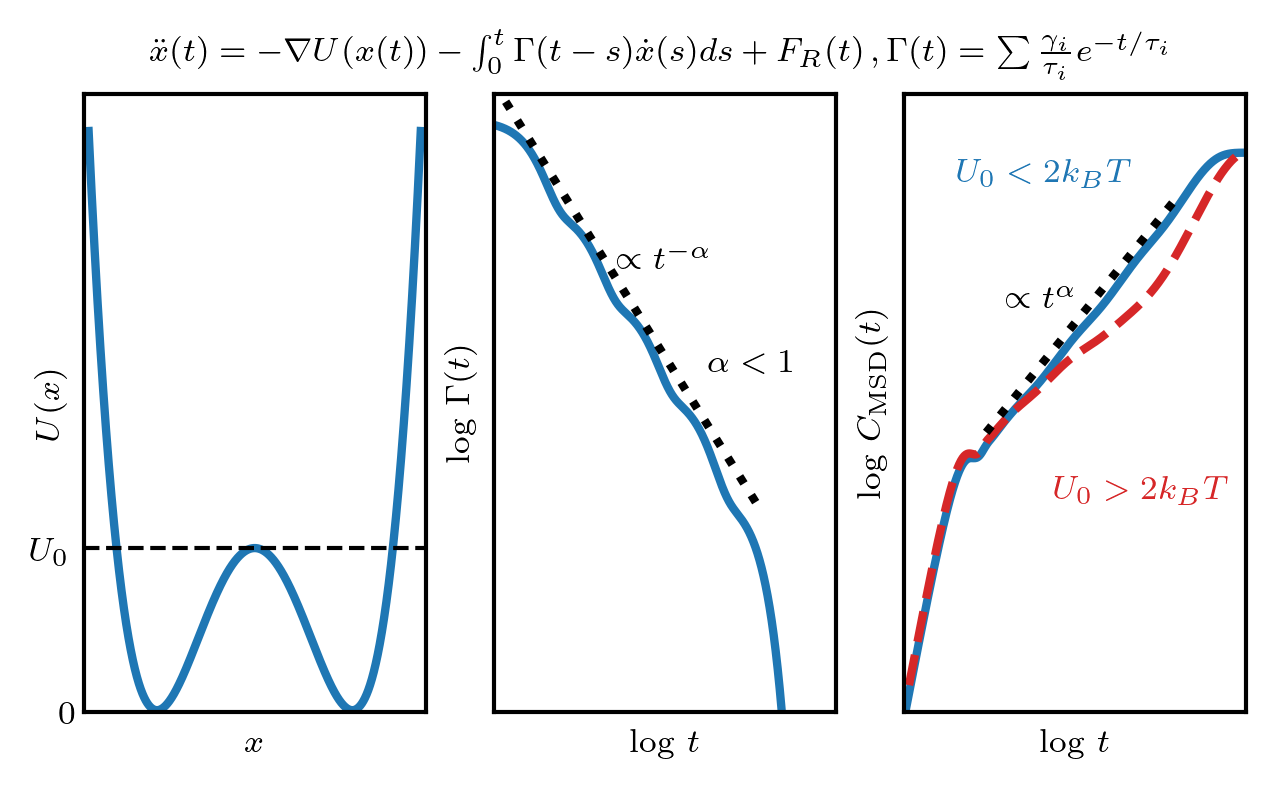

In [10]:
@mpltex.aps_decorator
def plot_graphical_abstract():   
    fig, ax = plt.subplots(1, 3, dpi=300, figsize=(5, 6 * 5 / 11))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    pos = np.linspace(-1.7*1, 0, int(1000 * 1))
    pos = np.unique(np.append(pos, np.linspace(0, 1.7*1, int(1000 * 1))))
    # print(np.unique(np.diff(pos)))
    Ull = 1
    fel = Ull * ((pos[np.where(pos<0)] / 1)**2 - 1)**2
    fer = Ull * ((pos[np.where(pos>=0)] / 1)**2 - 1)**2
    fe = np.append(fel, fer)
    ax[0].set_xlabel(r'$x$')
    ax[0].set_ylabel(r'$U(x)$')
    ax[0].plot(pos, fe, lw=2)#, c='blue'

    ax[0].set_xlim(-1.75, 1.75)
    ax[0].set_ylim(-0.01, 3.8)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].plot([-1.75, 1.75], [1, 1], c='k', ls='--')
    ax[0].text(-2.3, 0.92, r'$U_0$')
    ax[0].text(-2.0, -0.08, r'$0$')


    kT = 1#2.49
    prob = np.exp(-fe/kT)/ (np.sum(np.exp(-fe/kT))*(pos[1]-pos[0]))
    mu = np.sum(pos * prob) * (pos[1]-pos[0])
    varsq = np.sum((pos-mu)**2 * prob) * (pos[1]-pos[0]) 

    taud = 1
    taum = 1e-8
    
    L = 1
    m = taum * taud * kT / L**2
    K = kT / varsq / m
    K2 = 8 * Ull * kT / L**2 / m # local approximation by harmonic with Taylor
    B = L**2 / taum / taud
    tau_scaling = 1e-6
    gamma = np.array([1, 5, 5**2, 5**3, 5**4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 10, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 20, 20**2, 20**3, 20**4])
    amps = gamma / m / tau 
    msdc20d5 = msd_five_expo_harm(*amps,  *tau,  B, K, t)/np.sqrt(2)# * np.sum(gamma)**2 / m**2 / B
    alphac20d5 = np.diff(np.log(msdc20d5))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc20d5 = kernel_exp(t, 20.0, 5.0, 5, tau_scaling, 1)
    
    
    ax[1].plot(t * np.sum(gamma)/m, kernc20d5/kernc20d5[0], lw=2, label=r'$d=5$')
    ax[2].plot(t*np.sum(gamma)/m, msdc20d5, label=r'$d=5$', lw=2)

    msd, alpha = load_dw_msd_alpha(20, 5, 4.0, 5, int(tau_scaling/taum), 100.0, taum, nsteps='1e8', av=1009)
    ax[2].plot(msd[1,np.where(msd[1,:-1] < 50)[0]]*np.sum(gamma)/m, msd[0,np.where(msd[1,:-1] < 50)[0]], ls='--', lw=2)


    
    alpha_sub = np.log(20/5)/np.log(20)
    ax[1].plot(t[np.where(t<max(tau))] * np.sum(gamma)/m, 15 * t[np.where(t<max(tau))]**(-alpha_sub)/t[0]**(-alpha_sub), c='k', ls=':', lw=2)

    t = np.logspace(-1, 10, 10000)
    ax[2].plot(t[np.where((t>4e3) & (t<3e7))], 2e-4 * t[np.where((t>4e3) & (t<3e7))]**(alpha_sub+0.01), c='k', ls=':', lw=2)

    ax[1].loglog()
    ax[2].loglog()

    ax[1].set_ylim(1e-4, 1.5)
    ax[1].set_xlim(10, 1e9)

    ax[2].set_xlim(80, 1e9)
    ax[2].set_ylim(6e-5, 5)

    ax[1].set_xlabel(r'$\rm{log}$ $t$')
    ax[2].set_xlabel(r'$\rm{log}$ $t$')

    ax[1].set_ylabel(r'$\rm{log}$ $\Gamma(t)$')
    ax[2].set_ylabel(r'$\rm{log}$ $C_{\rm{MSD}}(t)$')

    ax[1].text(7e3, 1e-1, r'$\propto t^{-\alpha}$')
    ax[2].text(1e4, 0.1, r'$\propto t^{\alpha}$')

    ax[2].text(1e3, 1, r'$U_0<2k_BT$', c=colors[0])
    ax[2].text(1e5, 3e-3, r'$U_0>2k_BT$', c=colors[1])

    ax[1].text(9e-8, 2.5, r"$\ddot{x}(t)=-\nabla U(x(t)) -\int_{0}^{t} \Gamma(t-s)\dot{x}(s) ds + F_R(t)\,,$")
    ax[1].text(1.6e10, 2.5, r'$\Gamma(t)=\sum\frac{\gamma_i}{\tau_i}e^{-t/\tau_i}$')


    ax[1].text(1e6, 2e-2, r'$\alpha<1$')

    ax[1].set_xticks([])
    ax[2].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_yticks([], minor=True)
    ax[2].set_yticks([])
    ax[2].set_yticks([], minor=True)

    # plt.savefig('graphical_abstract.png', bbox_inches='tight')

plot_graphical_abstract()
plt.show()

# Fig 1

0.7807117 0.33000423


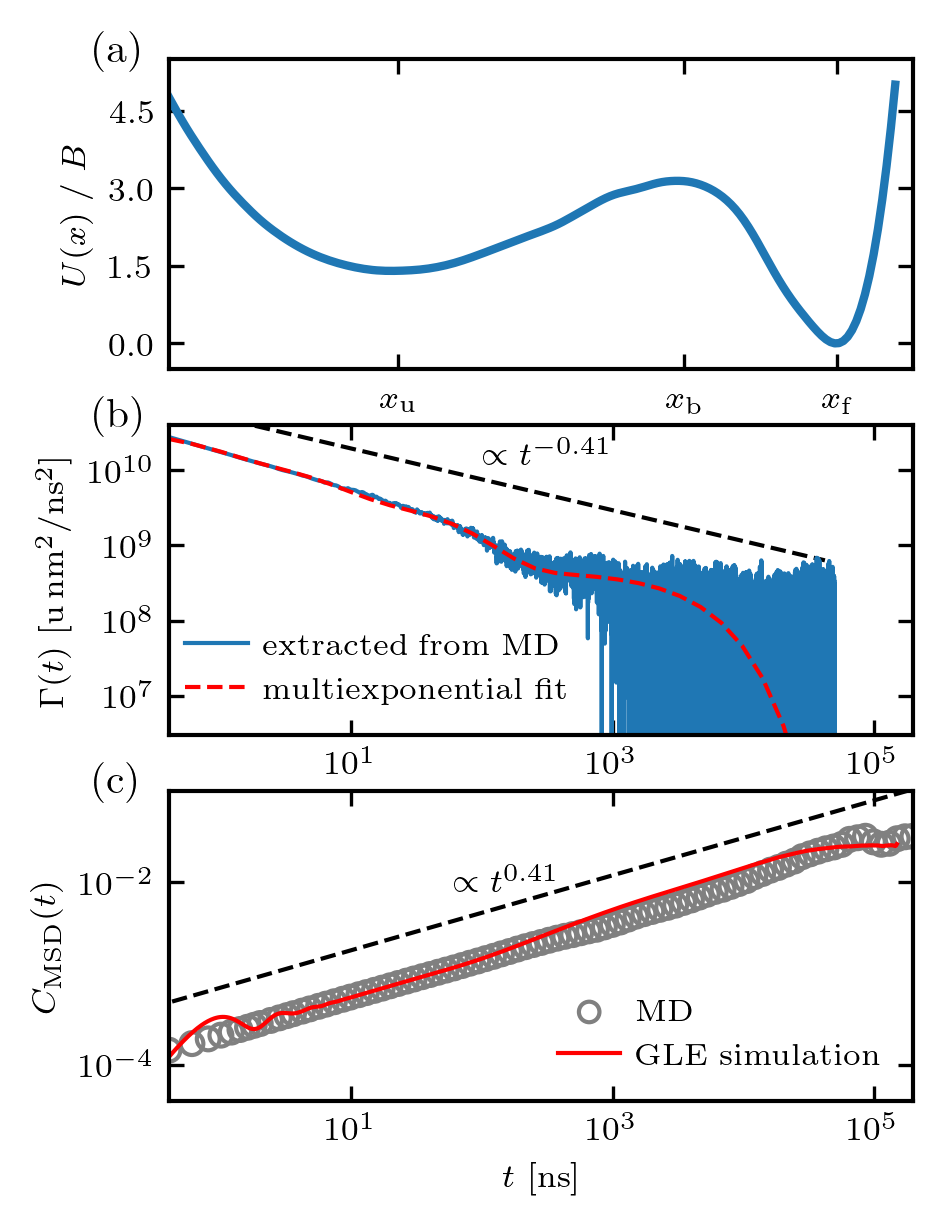

In [11]:
@mpltex.aps_decorator
def plot_fig1_kern():
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    fig, ax = plt.subplots(3, 1, dpi=300, figsize=(3.2, 4.6))

    alpha3d_kern = np.loadtxt('alpha_3D.txt')

    # gamma_alpha3d, tau_alpha3d = np.array([1.96e12, 2.39e11, 5.36e10]), np.array([4300.0, 63.0, 4.9])
    gamma_alpha3d, tau_alpha3d = np.array([1.96e12, 2.39e11, 5.36e10, 1.4e10]), np.array([4300.0, 63.0, 4.9, 0.63]) # as in Dalton et al PNAS 2023 fit, but with additional short time memory according to estimated c from Klimek et al PNAS 2025


    msd_alpha3d = np.loadtxt('Q_11.txt')
    msd_fiteye4 = np.load('./msd/msd_av1009alpha3d_fiteye4_bins100_r0.775_l0.38_tm1.5_n1e8_dt1.0.npy')
    log_ind_md = np.unique(np.int64(np.logspace(0, np.log10(len(msd_alpha3d[:, 1])-1), 100)))
    msd_alpha3d_log = np.array([msd_alpha3d[log_ind_md, 0], msd_alpha3d[log_ind_md, 1]]).T

    xlim = [0.4, 2e5] # [0.2, 3e4]
    ylim = [3e6, 4e10]

    t = alpha3d_kern[:, 0]
    n_orig = 10000
    xpos_text = 100
    alpha_sub = 0.41
    text_fac = 1.6
    pref_pow = 5e10

    ind_smooth_orig, smooth_log_kern_orig = log_smoothing(alpha3d_kern[:, 1], n_orig)
    ind_smooth, smooth_log_kern = log_smoothing(alpha3d_kern[1:, 1], 35)
    ax[1].text(xpos_text, 1/xpos_text**alpha_sub * pref_pow * text_fac, r'$\propto t^{-'+ str(alpha_sub) + r'}$')
    fit = multiexp_plot(t[ind_smooth],gamma_alpha3d, tau_alpha3d)
    ax[1].plot(t[ind_smooth], pref_pow * t[ind_smooth]**(-alpha_sub), c='k', ls='--')
    ax[1].plot(t, alpha3d_kern[:, 1], label=r'$\rm{extracted}$ $\rm{from}$ $\rm{MD}$')

    
    ax[1].plot(t[ind_smooth], fit, c='r', ls='--', label=r'$\rm{multiexponential}$ $\rm{fit}$')
    ax[1].loglog()

    ax[2].scatter(msd_alpha3d_log[:,0], msd_alpha3d_log[:,1], facecolor='None', edgecolor='grey', s=30, label=r'$\rm{MD}$')
    ax[2].plot(msd_fiteye4[1,:]*0.001, msd_fiteye4[0,:], ls='-', c='r', lw=1, label=r'$\rm{GLE}$ $\rm{simulation}$')

    ax[2].plot(msd_alpha3d_log[:,0], 7e-4 * msd_alpha3d_log[:,0]**0.41, c='k', ls='--')
    ax[2].loglog()



    fe_alpha3d = np.loadtxt('fe_kde_unscaled_11_alpha3D_Best_3_16.txt', delimiter=',')
    ax[0].plot(fe_alpha3d[:,0], fe_alpha3d[:,2] - np.min(fe_alpha3d[:,2]), lw=2)#, c='blue'
    print(np.max(fe_alpha3d[:,0]), np.min(fe_alpha3d[:,0]))

    ax[0].set_ylabel(r'$U(x)$ $/$ $B$')
    ax[0].set_ylim(-0.5, 5.5)
    ax[0].set_xlim(0.4, 0.79)

    ax[0].set_xticks([0.52, 0.67, 0.75])
    ax[0].set_xticklabels([r'$x_{\rm{u}}$', r'$x_{\rm{b}}$', r'$x_{\rm{f}}$'])
    ax[0].set_yticks([0, 1.5, 3, 4.5])

    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(4e-5, 1e-1)

    ax[2].set_xlim(xlim)
    ax[2].text(60, 0.008, r'$\propto t^{0.41}$')
    ax[2].set_ylabel(r'$C_{\rm{MSD}}(t)$')
    ax[2].set_xlabel(r'$t$ $[\rm{ns}]$')
    # ax[1].set_xlabel(r'$t$ $[\rm{ns}]$')
    ax[1].set_ylabel(r'$\Gamma (t)$ $[\rm{u}\,\rm{nm}^2/\rm{ns}^2]$')

    ax[1].set_yticks([1e7, 1e8, 1e9, 1e10])
    ax[2].set_yticks([1e-4, 1e-2])

    ax[2].legend(loc='lower right')
    ax[1].legend(loc='lower left', bbox_to_anchor=(-0.02, 0))

    subplotlabels = [r'$\rm{(a)}$', r'$\rm{(b)}$', r'$\rm{(c)}$']
    axes = [ax[0], ax[1], ax[2]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(-0.25, 0.1, fig.dpi_scale_trans)
       axes[i].text(0.0, 1.0, subplotlabel, fontsize=10, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))

    plt.subplots_adjust(wspace=0.27, hspace=0.18)

plot_fig1_kern()
# plt.savefig('motivation_plot.svg', bbox_inches='tight')

plt.show()

# Fig. 2

/tmp/ipykernel_4094316/278690580.py:212: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0, 1].loglog()
/tmp/ipykernel_4094316/278690580.py:351: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0, 0].loglog()
/tmp/ipykernel_4094316/278690580.py:364: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[2, 0].set_xticks([1, 1e2, 1e4, 1e6])


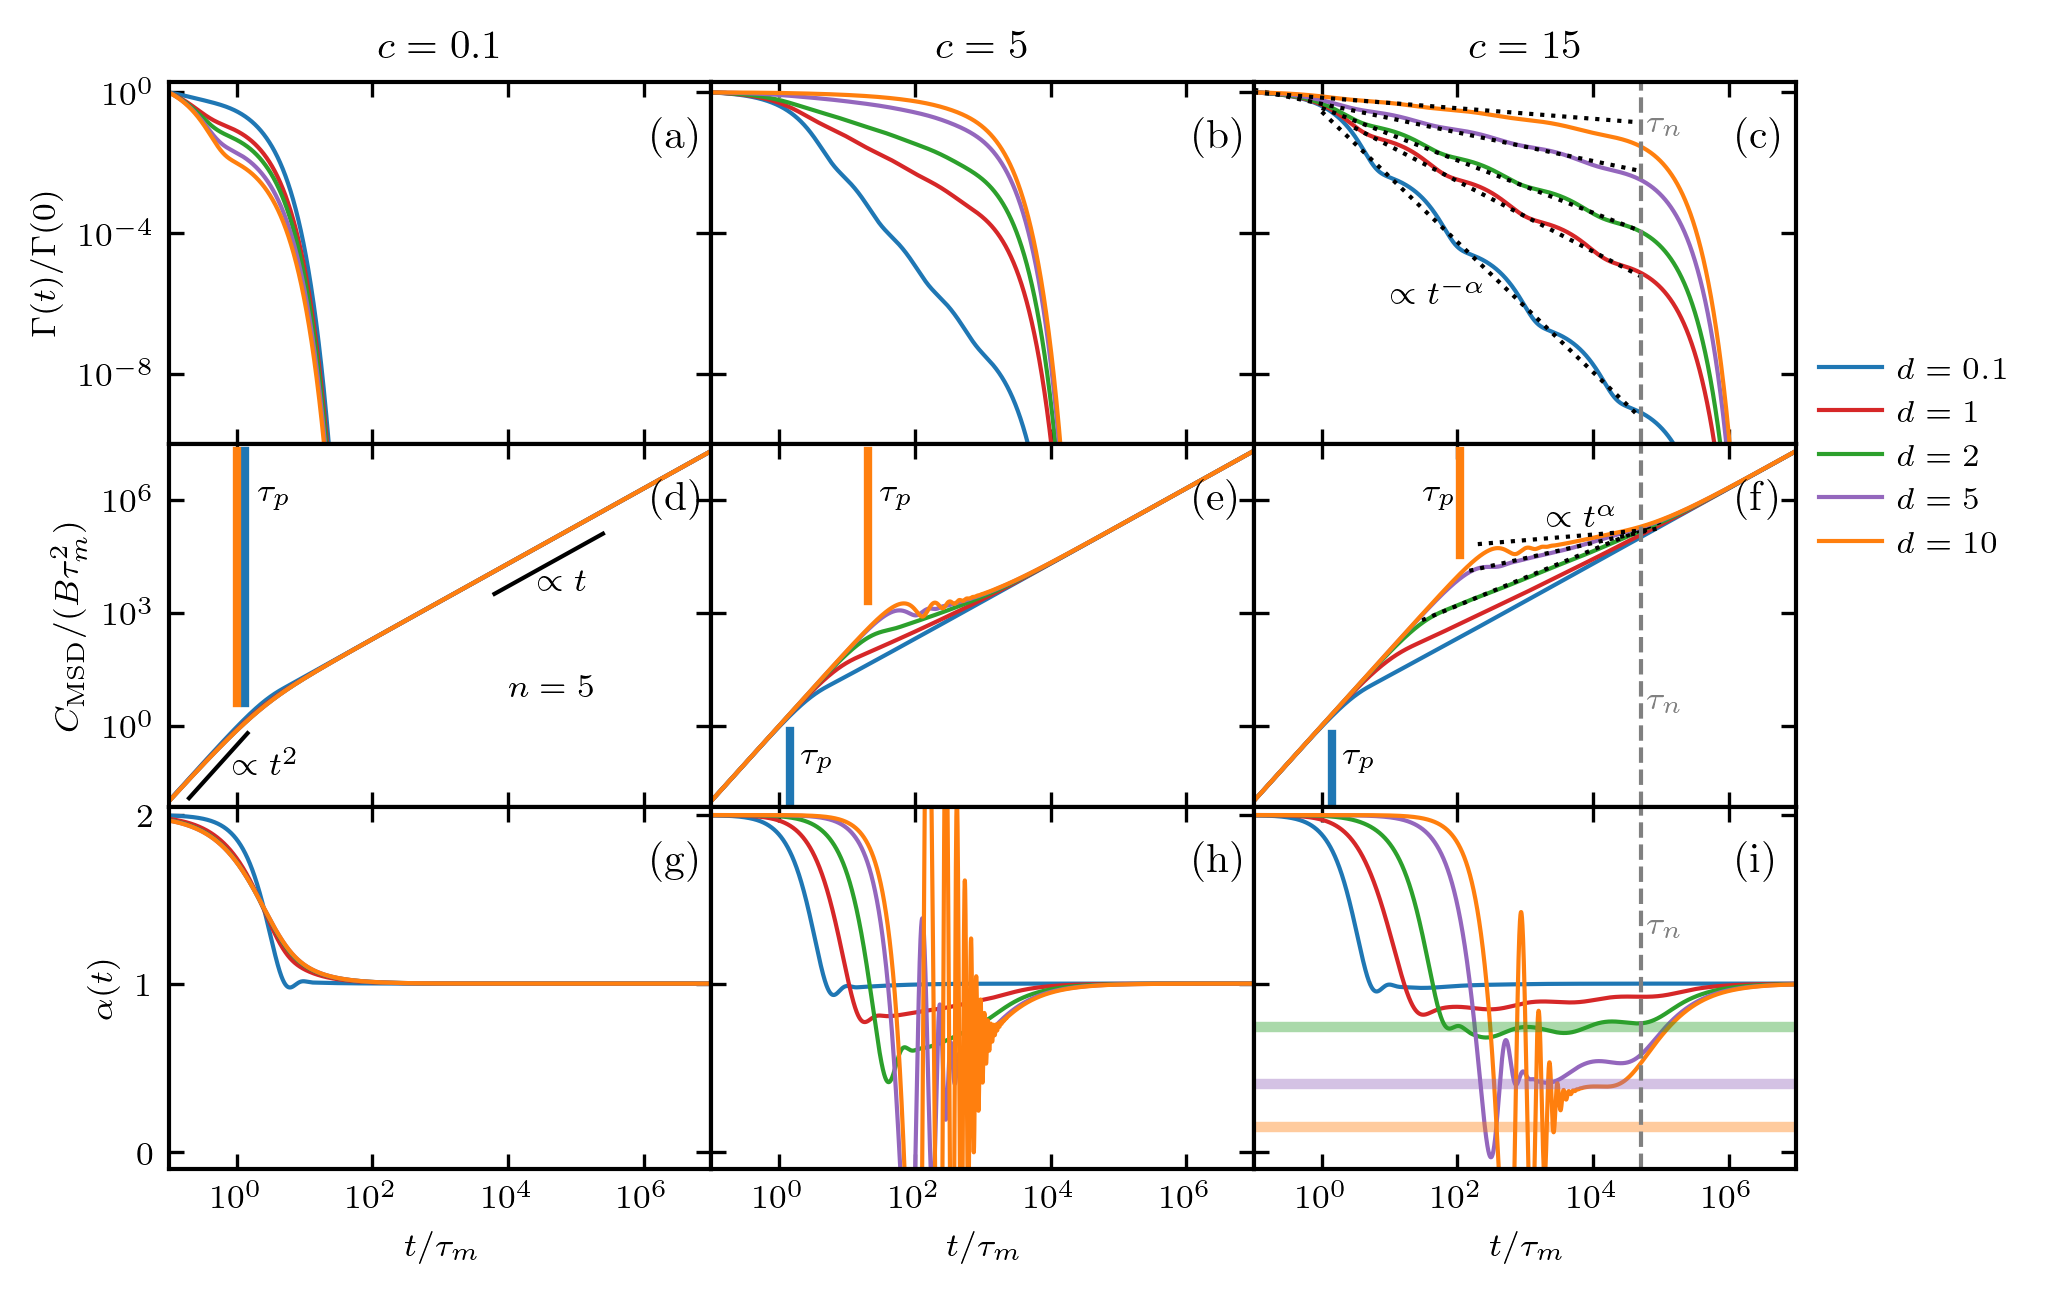

In [12]:
@mpltex.aps_decorator
def msd_alpha_kernel_n5(tau_m, tau_scaling, n_iterate=1000):
    fig, ax = plt.subplots(3, 3, sharex=True, dpi=300, figsize=(7, 4.8))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    ax[1, 0].set_yticks([0, 1, 2])
    ax[1, 1].set_yticks([0, 1, 2])
    
    ax[1, 2].set_yticks([0, 1, 2])

    ax[1, 0].set_xticks([1, 1e2, 1e4, 1e6])
    ax[1, 1].set_xticks([1, 1e2, 1e4, 1e6])
    
    ax[1, 2].set_xticks([1, 1e2, 1e4, 1e6])

    ax[1, 0].tick_params('x', top=True)
    ax[1, 1].tick_params('x', top=True)
    
    ax[1, 2].tick_params('x', top=True)

    taud = 1
    taum = tau_m * taud
    L = 1
    kT = 1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud

    ax[0, 0].set_title(r'$c = 0.1$')

    gamma = np.array([1, 0.1, 0.01, 1e-3, 1e-4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01, 1e-3, 1e-4])
    amps = gamma / m / tau 
    msdc01d01_lim = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac01d01 = np.diff(np.log(msdc01d01_lim))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc01d01 = kernel_exp(t[np.where(t<1000*max(tau))], 0.1, 0.1, 5, tau_scaling * taum, gamma[0])
    ax[2, 0].plot(t[:-1]*np.sum(gamma)/m, alphac01d01, label=r'$d=0.1$')
    ax[1, 0].plot(t*np.sum(gamma)/m, msdc01d01_lim, label=r'$d=0.1$')
    ax[0, 0].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc01d01/kernc01d01[0] , label=r'$d=0.1$') #* (np.sum(gamma)/m)**2

    time_scale = m / np.sum(gamma)
    for i in range(n_iterate):
        time_scale = m / int_kernel_exp(time_scale, amps, tau)

    ax[1, 0].plot([time_scale, time_scale], [4, np.max(msdc01d01_lim)], c=colors[0], ls='-', lw=2)

    alpha_sub = np.log(0.1/0.1)/np.log(0.1)

    gamma = np.array([1, 1, 1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01, 1e-3, 1e-4])
    amps = gamma / m / tau 
    msdc01d1 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac01d1 = np.diff(np.log(msdc01d1))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc01d1 = kernel_exp(t[np.where(t<1000*max(tau))], 0.1, float(1.0), 5, tau_scaling * taum, gamma[0])
    ax[2, 0].plot(t[:-1]*np.sum(gamma)/m, alphac01d1, label=r'$d=1$')
    ax[1, 0].plot(t*np.sum(gamma)/m, msdc01d1, label=r'$d=1$')
    ax[0, 0].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc01d1/kernc01d1[0] , label=r'$d=1$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(0.1/1)/np.log(0.1)

    gamma = np.array([1, 2, 4, 8, 16])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01, 1e-3, 1e-4])
    amps = gamma / m / tau 
    msdc01d2 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    # ax[0, 0].plot(t*np.sum(gamma)/m, msdc01d2, label=r'$d=2$', ls='-')
    alphac01d2 = np.diff(np.log(msdc01d2))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc01d2 = kernel_exp(t[np.where(t<1000*max(tau))], 0.1, 2.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 0].plot(t[:-1]*np.sum(gamma)/m, alphac01d2, label=r'$d=2$')
    ax[1, 0].plot(t*np.sum(gamma)/m, msdc01d2, label=r'$d=2$')
    ax[0, 0].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc01d2/kernc01d2[0] , label=r'$d=2$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(0.1/2)/np.log(0.1)

    gamma = np.array([1, 5, 25, 125, 5**4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01, 1e-3, 1e-4])
    amps = gamma / m / tau 
    msdc01d5 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac01d5 = np.diff(np.log(msdc01d5))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc01d5 = kernel_exp(t[np.where(t<1000*max(tau))], 0.1, 5.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 0].plot(t[:-1]*np.sum(gamma)/m, alphac01d5, label=r'$d=5$')
    ax[1, 0].plot(t*np.sum(gamma)/m, msdc01d5, label=r'$d=5$')
    ax[0, 0].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc01d5/kernc01d5[0] , label=r'$d=5$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(0.1/5)/np.log(0.1)

    gamma = np.array([1, 10, 100, 1e3, 1e4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01, 1e-3, 1e-4])
    amps = gamma / m / tau 
    msdc01d10 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac01d10 = np.diff(np.log(msdc01d10))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc01d10 = kernel_exp(t[np.where(t<1000*max(tau))], 0.1, 10.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 0].plot(t[:-1]*np.sum(gamma)/m, alphac01d10, label=r'$d=10$')
    ax[1, 0].plot(t*np.sum(gamma)/m, msdc01d10, label=r'$d=10$')
    ax[0, 0].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc01d10/kernc01d10[0] , label=r'$d=10$') #* (np.sum(gamma)/m)**2

    time_scale = m / np.sum(gamma)
    for i in range(n_iterate):
        time_scale = m / int_kernel_exp(time_scale, amps, tau)

    ax[1, 0].plot([time_scale, time_scale], [4, np.max(msdc01d10)], c=colors[4], ls='-', lw=2)

    alpha_sub = np.log(0.1/10)/np.log(0.1)


    ax[1, 0].set_xlabel(r'$t/\tau_{m}$')
    ax[1, 0].set_ylabel(r'$C_{\rm{MSD}} /(B \tau_{m}^2)$')
    ax[1, 0].loglog()

    ax[1, 0].plot(t[370:1450]*np.sum(gamma)/m, 0.3*(t[370:1450]*np.sum(gamma)/m)**2, c='k')
    ax[1, 0].plot(t[6000:8000]*np.sum(gamma)/m, 0.5*t[6000:8000]*np.sum(gamma)/m, c='k')

    ax[1, 0].text(0.85, 0.05, r'$\propto t^2$')
    ax[1, 0].text(2.7e4, 4e3, r'$\propto t$')


    ax[0, 1].set_title(r'$c = 5$')

    gamma = np.array([1, 0.1, 0.01, 1e-3, 1e-4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25, 125, 5**4])

    amps = gamma / m / tau 
    msdc5d01 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac5d01 = np.diff(np.log(msdc5d01))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc5d01 = kernel_exp(t[np.where(t<1000*max(tau))], 5, 0.1, 5, tau_scaling * taum, gamma[0])
    ax[2, 1].plot(t[:-1]*np.sum(gamma)/m, alphac5d01, label=r'$d=0.1$')
    ax[1, 1].plot(t*np.sum(gamma)/m, msdc5d01, label=r'$d=0.1$')
    ax[0, 1].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc5d01/kernc5d01[0] , label=r'$d=0.1$') #* (np.sum(gamma)/m)**2

    time_scale = m / np.sum(gamma)
    for i in range(n_iterate):
        time_scale = m / int_kernel_exp(time_scale, amps, tau)

    ax[1, 1].plot([time_scale, time_scale], [min(msdc5d01), 0.7], c=colors[0], ls='-', lw=2)

    alpha_sub = np.log(5/0.1)/np.log(5)

    gamma = np.array([1, 1, 1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25, 125, 5**4])
    amps = gamma / m / tau 
    msdc5d1 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac5d1 = np.diff(np.log(msdc5d1))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc5d1 = kernel_exp(t[np.where(t<1000*max(tau))], 5.0, 1.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 1].plot(t[:-1]*np.sum(gamma)/m, alphac5d1, label=r'$d=1$')
    ax[1, 1].plot(t*np.sum(gamma)/m, msdc5d1, label=r'$d=1$')
    ax[0, 1].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc5d1/kernc5d1[0] , label=r'$d=1$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(5/1)/np.log(5)

    gamma = np.array([1, 2, 4, 8, 16])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25, 125, 5**4])
    amps = gamma / m / tau 
    msdc5d2 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac5d2 = np.diff(np.log(msdc5d2))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc5d2 = kernel_exp(t[np.where(t<1000*max(tau))], 5.0, 2.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 1].plot(t[:-1]*np.sum(gamma)/m, alphac5d2, label=r'$d=2$')
    ax[1, 1].plot(t*np.sum(gamma)/m, msdc5d2, label=r'$d=2$')
    ax[0, 1].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc5d2/kernc5d2[0] , label=r'$d=2$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(5/2)/np.log(5)

    gamma = np.array([1, 5, 25, 125, 5**4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25, 125, 5**4])
    amps = gamma / m / tau 
    msdc5d5 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac5d5 = np.diff(np.log(msdc5d5))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc5d5 = kernel_exp(t[np.where(t<1000*max(tau))], 5.0, 5.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 1].plot(t[:-1]*np.sum(gamma)/m, alphac5d5, label=r'$d=5$')
    ax[1, 1].plot(t*np.sum(gamma)/m, msdc5d5, label=r'$d=5$')
    ax[0, 1].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc5d5/kernc5d5[0] , label=r'$d=5$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(5/5)/np.log(5)

    gamma = np.array([1, 10, 100, 1e3, 1e4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25, 125, 5**4])
    amps = gamma / m / tau 
    msdc5d10 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac5d10 = np.diff(np.log(msdc5d10))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc5d10 = kernel_exp(t[np.where(t<1000*max(tau))], 5.0, 10.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 1].plot(t[:-1]*np.sum(gamma)/m, alphac5d10, label=r'$d=10$')
    ax[1, 1].plot(t*np.sum(gamma)/m, msdc5d10, label=r'$d=10$')
    ax[0, 1].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc5d10/kernc5d10[0] , label=r'$d=10$') #* (np.sum(gamma)/m)**2

    time_scale = m / np.sum(gamma)
    for i in range(n_iterate):
        time_scale = m / int_kernel_exp(time_scale, amps, tau)

    ax[1, 1].plot([time_scale, time_scale], [2e3, np.max(msdc5d10)], c=colors[4], ls='-', lw=2)

    alpha_sub = np.log(5/10)/np.log(5)

    ax[0, 1].set_xlabel(r'$t/\tau_{m}$')
    ax[0, 1].loglog()



    ax[0, 2].set_title(r'$c = 15$')

    gamma = np.array([1, 0.1, 0.01, 1e-3, 1e-4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 15, 15**2, 15**3, 15**4])

    amps = gamma / m / tau 
    msdc100d01 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac100d01 = np.diff(np.log(msdc100d01))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc100d01 = kernel_exp(t[np.where(t<1000*max(tau))], 15.0, 0.1, 5, tau_scaling * taum, gamma[0])
    ax[2, 2].plot(t[:-1]*np.sum(gamma)/m, alphac100d01, label=r'$d=0.1$')
    ax[1, 2].plot(t*np.sum(gamma)/m, msdc100d01, label=r'$d=0.1$')
    ax[0, 2].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc100d01/kernc100d01[0] , label=r'$d=0.1$') #* (np.sum(gamma)/m)**2



    alpha_sub = np.log(15/0.1)/np.log(15)
    ax[0, 2].plot(t[np.where((t<max(tau)) & (t>1))], 20 * t[np.where((t<max(tau)) & (t>1))]**(-alpha_sub)/t[0]**(-alpha_sub), c='k', ls=':')


    time_scale = m / np.sum(gamma)
    for i in range(n_iterate):
        time_scale = m / int_kernel_exp(time_scale, amps, tau)

    ax[1, 2].plot([time_scale, time_scale], [np.min(msdc100d01), 0.6], c=colors[0], ls='-', lw=2)


    gamma = np.array([1, 1, 1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 15, 15**2, 15**3, 15**4])
    amps = gamma / m / tau 
    msdc100d1 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac100d1 = np.diff(np.log(msdc100d1))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc100d1 = kernel_exp(t[np.where(t<1000*max(tau))], 15.0, 1.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 2].plot(t[:-1]*np.sum(gamma)/m, alphac100d1, label=r'$d=1$')
    ax[1, 2].plot(t*np.sum(gamma)/m, msdc100d1, label=r'$d=1$')
    ax[0, 2].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc100d1/kernc100d1[0] , label=r'$d=1$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(15/1)/np.log(15)
    ax[0, 2].plot(t[np.where((t<max(tau)) & (t>3))], 3 * t[np.where((t<max(tau)) & (t>3))]**(-alpha_sub)/t[0]**(-alpha_sub), c='k', ls=':')


    gamma = np.array([1, 2, 4, 8, 16])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 15, 15**2, 15**3, 15**4])
    amps = gamma / m / tau 
    msdc100d2 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac100d2 = np.diff(np.log(msdc100d2))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc100d2 = kernel_exp(t[np.where(t<1000*max(tau))], 15.0, 2.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 2].plot(t[:-1]*np.sum(gamma)/m, alphac100d2, label=r'$d=2$')
    ax[1, 2].plot(t*np.sum(gamma)/m, msdc100d2, label=r'$d=2$')
    ax[0, 2].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc100d2/kernc100d2[0] , label=r'$d=2$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(15/2)/np.log(15)
    ax[0, 2].plot(t[np.where((t<max(tau)) & (t>1))], 2 * t[np.where((t<max(tau)) & (t>1))]**(-alpha_sub)/t[0]**(-alpha_sub), c='k', ls=':')
    ax[1, 2].plot(t[np.where((t<1e5) & (t>30))[0]], 50 * t[np.where((t<1e5) & (t>30))[0]]**(alpha_sub), c='k', ls=':')


    gamma = np.array([1, 5, 25, 125, 5**4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 15, 15**2, 15**3, 15**4])
    amps = gamma / m / tau 
    msdc100d5 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac100d5 = np.diff(np.log(msdc100d5))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc100d5 = kernel_exp(t[np.where(t<1000*max(tau))], 15.0, 5.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 2].plot(t[:-1]*np.sum(gamma)/m, alphac100d5, label=r'$d=5$')
    ax[1, 2].plot(t*np.sum(gamma)/m, msdc100d5, label=r'$d=5$')
    ax[0, 2].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc100d5/kernc100d5[0] , label=r'$d=5$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(15/5)/np.log(15)
    ax[0, 2].plot(t[np.where(t<max(tau))], 1.2 * t[np.where(t<max(tau))]**(-alpha_sub)/t[0]**(-alpha_sub), c='k', ls=':')
    ax[1, 2].plot(t[np.where((t<1e5) & (t>150))[0]], 1.7e3 * t[np.where((t<1e5) & (t>150))[0]]**(alpha_sub), c='k', ls=':')


    gamma = np.array([1, 10, 100, 1e3, 1e4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 15, 15**2, 15**3, 15**4])
    amps = gamma / m / tau 
    msdc100d10 = msd_five_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    alphac100d10 = np.diff(np.log(msdc100d10))/np.diff(np.log(t*np.sum(gamma)/m))
    kernc100d10 = kernel_exp(t[np.where(t<1000*max(tau))], 15.0, 10.0, 5, tau_scaling * taum, gamma[0])
    ax[2, 2].plot(t[:-1]*np.sum(gamma)/m, alphac100d10, label=r'$d=10$')
    ax[1, 2].plot(t*np.sum(gamma)/m, msdc100d10, label=r'$d=10$')
    ax[0, 2].plot(t[np.where(t<1000*max(tau))] * np.sum(gamma)/m, kernc100d10/kernc100d10[0] , label=r'$d=10$') #* (np.sum(gamma)/m)**2

    alpha_sub = np.log(15/10)/np.log(15)
    ax[0, 2].plot(t[np.where(t<max(tau))], t[np.where(t<max(tau))]**(-alpha_sub)/t[0]**(-alpha_sub), c='k', ls=':')
    ax[1, 2].plot(t[np.where((t<7e4) & (t>2e2))[0]], 3e4 * t[np.where((t<7e4) & (t>2e2))[0]]**(alpha_sub), c='k', ls=':')


    time_scale = m / np.sum(gamma)
    for i in range(n_iterate):
        time_scale = m / int_kernel_exp(time_scale, amps, tau)

    ax[1, 2].plot([time_scale, time_scale], [3.5e4, np.max(msdc100d10)], c=colors[4], ls='-', lw=2)


    ax[0, 2].legend(loc='lower right', bbox_to_anchor=[1.45, -0.4])
    ax[0, 2].set_xlabel(r'$t/\tau_{m}$')
    ax[0, 2].loglog()


    ax[2, 0].set_xlabel(r'$t/\tau_{m}$')
    ax[2, 0].set_ylabel(r'$\alpha (t)$')
    ax[2, 0].semilogx()
    
    ax[2, 1].set_xlabel(r'$t/\tau_{m}$')
    # ax[1, 1].set_ylabel(r'$\alpha (t)$')
    ax[2, 1].semilogx()


    ax[2, 2].plot([t[0]*np.sum(gamma)/m, 1e7], [np.log(15/2)/np.log(15), np.log(15/2)/np.log(15)], c=colors[2], alpha=0.4, ls='-', lw=2.5)
    ax[2, 2].plot([t[0]*np.sum(gamma)/m, 1e7], [np.log(15/5)/np.log(15), np.log(15/5)/np.log(15)], c=colors[3], alpha=0.4, ls='-', lw=2.5)
    ax[2, 2].plot([t[0]*np.sum(gamma)/m, 1e7], [np.log(15/10)/np.log(15), np.log(15/10)/np.log(15)], c=colors[4], alpha=0.4, ls='-', lw=2.5)
   

    ax[2, 2].set_xlabel(r'$t/\tau_{m}$')
    ax[2, 2].semilogx()

    ax[2, 0].set_ylim(-0.1,2.05)
    ax[2, 1].set_ylim(-0.1,2.05)
    
    ax[2, 2].set_ylim(-0.1,2.05)
    ax[1, 1].loglog()
    ax[1, 2].loglog()
    ax[2, 0].set_yticks([0, 1, 2])
    ax[2, 1].set_yticks([0, 1, 2])
    ax[2, 2].set_yticks([0, 1, 2])
    ax[2, 1].set_yticklabels([])
    ax[2, 2].set_yticklabels([])
    ax[0, 0].loglog()
    ax[0, 1].loglog()
    ax[0, 2].loglog()


    ax[2, 1].set_yticklabels([])
    
    ax[2, 2].set_yticklabels([])

    ax[1, 1].set_yticklabels([])
    
    ax[1, 2].set_yticklabels([])

    ax[2, 0].set_xticks([1, 1e2, 1e4, 1e6])
    ax[2, 1].set_xticks([1, 1e2, 1e4, 1e6])
    
    ax[2, 2].set_xticks([1, 1e2, 1e4, 1e6])

    ax[1, 0].set_yticks([1, 1e3, 1e6])
    ax[1, 1].set_yticks([1, 1e3, 1e6])
    
    ax[1, 2].set_yticks([1, 1e3, 1e6])

    ax[1, 0].set_ylim(np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5)
    ax[1, 1].set_ylim(np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5)
    
    ax[1, 2].set_ylim(np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5)

    ax[1, 0].text(1e4, 6, r'$n=5$')
    ax[1, 2].text(30, 1e6, r'$\tau_p$')
    ax[1, 2].text(2, 0.1, r'$\tau_p$')

    ax[1, 1].text(30, 1e6, r'$\tau_p$')
    ax[1, 1].text(2, 0.1, r'$\tau_p$')

    ax[1, 0].text(2, 1e6, r'$\tau_p$')

    subplotlabels = [r'$\rm{(a)}$', r'$\rm{(b)}$', r'$\rm{(c)}$']

    axes = [ax[0,0], ax[0,1], ax[0,2]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(1.61, -8/72, fig.dpi_scale_trans)
       axes[i].text(0.0, 1.0, subplotlabel, fontsize=10, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))

    subplotlabels = [r'$\rm{(d)}$', r'$\rm{(e)}$', r'$\rm{(f)}$']
    axes = [ax[1,0], ax[1,1], ax[1,2]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(1.61, -8/72, fig.dpi_scale_trans)
       axes[i].text(0.0, 1.0, subplotlabel, fontsize=10, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))
       
    subplotlabels = [r'$\rm{(g)}$', r'$\rm{(h)}$', r'$\rm{(i)}$']
    axes = [ax[2,0], ax[2,1], ax[2,2]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(1.61, -8/72, fig.dpi_scale_trans)#1.66
       axes[i].text(0.0, 1.0, subplotlabel, fontsize=10, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))


    ax[0, 2].plot([15**4, 15**4], [1e-10, 2], c='gray', ls='--')
    ax[1, 2].plot([15**4, 15**4], [np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5], c='gray', ls='--')
    ax[2, 2].plot([15**4, 15**4], [-0.1,2.05], c='gray', ls='--')

    ax[0, 2].text(15**4*1.2, 0.08, r'$\tau_n$', c='gray')
    ax[1, 2].text(15**4*1.2, 3, r'$\tau_n$', c='gray')
    ax[2, 2].text(15**4*1.2, 1.3, r'$\tau_n$', c='gray')

    ax[0, 0].set_ylim(1e-10, 2)
    ax[0, 1].set_ylim(1e-10, 2)
    ax[0, 2].set_ylim(1e-10, 2)

    ax[0, 0].set_yticks([1e-8, 1e-4, 1])
    ax[0, 1].set_yticks([1e-8, 1e-4, 1])
    ax[0, 2].set_yticks([1e-8, 1e-4, 1])
    ax[0, 1].set_yticklabels([])
    ax[0, 2].set_yticklabels([])

    ax[0, 0].set_ylabel(r'$\Gamma(t)/\Gamma(0)$')
    ax[0, 2].text(10, 1e-6, r'$\propto t^{-\alpha}$')
    ax[1, 2].text(2e3, 2e5, r'$\propto t^{\alpha}$')

    plt.subplots_adjust(wspace=0, hspace=0)


msd_alpha_kernel_n5(1, 1)
# plt.savefig('fig_SI_msd_alpha_n5.png', bbox_inches='tight')
plt.show()

# Fig. 3

/tmp/ipykernel_4094316/3774883138.py:17: RuntimeWarning: invalid value encountered in log
  ax.plot(d_list, (-np.log(d_list / c_list[j]) + np.log(1-(d_list / c_list[j])**(n)) - np.log(1-(d_list / c_list[j])**(n-1))) / np.log(c_list[j]), c='k', ls=':', lw=2) #for i=1 value between tau1 and tau2
/tmp/ipykernel_4094316/3774883138.py:17: RuntimeWarning: invalid value encountered in log
  ax.plot(d_list, (-np.log(d_list / c_list[j]) + np.log(1-(d_list / c_list[j])**(n)) - np.log(1-(d_list / c_list[j])**(n-1))) / np.log(c_list[j]), c='k', ls=':', lw=2) #for i=1 value between tau1 and tau2
/tmp/ipykernel_4094316/3774883138.py:17: RuntimeWarning: invalid value encountered in log
  ax.plot(d_list, (-np.log(d_list / c_list[j]) + np.log(1-(d_list / c_list[j])**(n)) - np.log(1-(d_list / c_list[j])**(n-1))) / np.log(c_list[j]), c='k', ls=':', lw=2) #for i=1 value between tau1 and tau2
/tmp/ipykernel_4094316/3774883138.py:17: RuntimeWarning: divide by zero encountered in log
  ax.plot(d_list, (-np.l

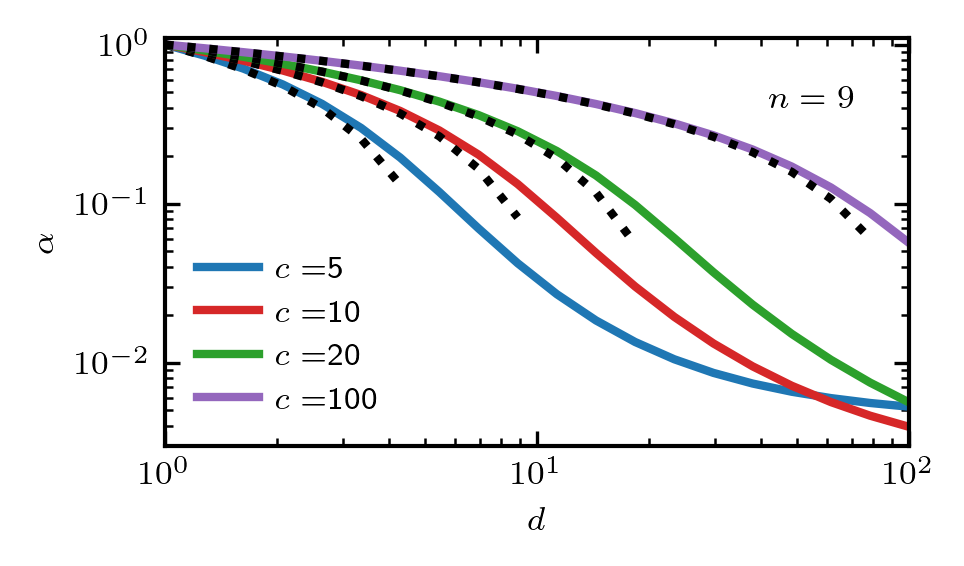

In [13]:
@mpltex.aps_decorator
def alpha_cd_plot(c_list, d_list, n, tau0=1):
    fig, ax = plt.subplots(1, 1, dpi=300, figsize=(3.2, 1.8))

    alpha_d_c_n5 = np.zeros((len(c_list), len(d_list)))

    x0 = np.array([0.5, 1.0])
    for i, d_in in enumerate(d_list):
        for j, c_in in enumerate(c_list):
            tarr = np.logspace(np.log10(tau0), np.log10(tau0* c_in**(n - 1)) - 1, 1000)
            res = least_squares(lambda x: sigma_kerns_alpha(x, tarr, c_in, d_in, n, tau0), x0, bounds=([0, 0], [1, np.inf]))
            alpha_d_c_n5[j, i] = res.x[0]


    for j in range(len(c_list)):
        ax.plot(d_list, alpha_d_c_n5[j, :], label=r'$c=$' + str(c_list[j]), lw=2)
        ax.plot(d_list, (-np.log(d_list / c_list[j]) + np.log(1-(d_list / c_list[j])**(n)) - np.log(1-(d_list / c_list[j])**(n-1))) / np.log(c_list[j]), c='k', ls=':', lw=2) #for i=1 value between tau1 and tau2


    ax.text(0.81, 0.83, r'$n=' + str(int(n)) + '$', transform=ax.transAxes)
    ax.loglog()
    ax.set_xlabel(r'$d$')
    ax.set_ylabel(r'$\alpha$')
    ax.legend(loc='lower left')
    ax.set_ylim(0.003, 1.1)
    # plt.savefig('fig_alpha_d_n' + str(int(n)) + '.png', bbox_inches='tight')

c_list = [5, 10, 20, 100]
d_list = np.logspace(0, 2, 20)
n=9
alpha_cd_plot(c_list, d_list, n, tau0=1)
plt.show()

# Fig. 4

1e-08
1e-06
0.0001


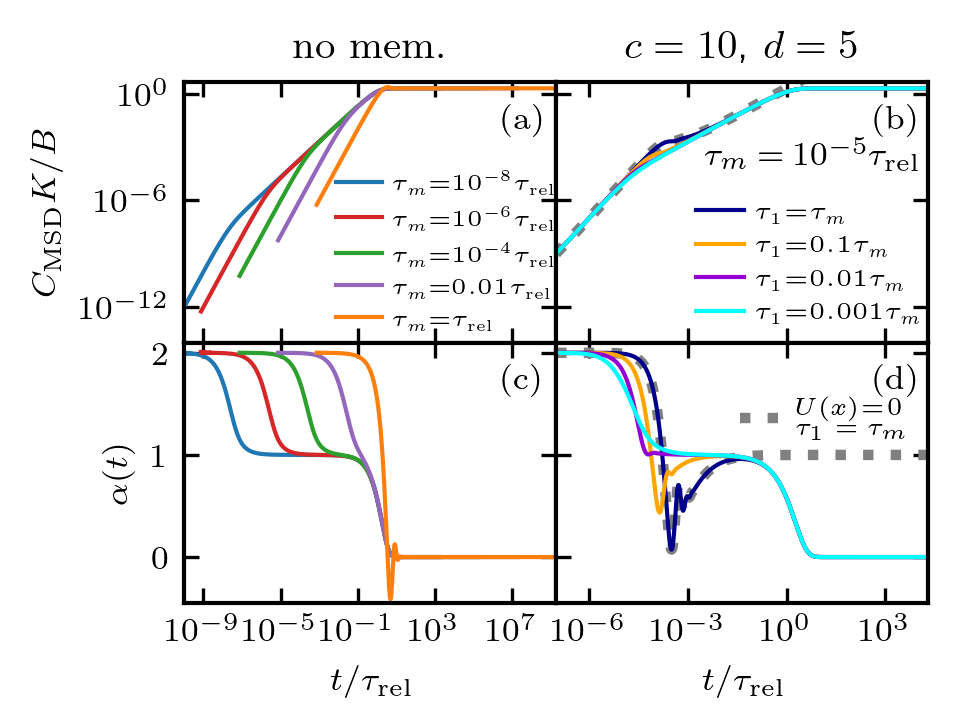

In [14]:
@mpltex.aps_decorator
def plot_hh(tmlh, tmh, T=300):
    fig, ax = plt.subplots(2, 2, dpi=300, figsize=(3.2, 2.3))
    taud = 1
    L = 1
    i=0
    kT = 2.49 *(T/300)
    colors2 = ['darkblue', 'orange', 'darkviolet', 'cyan']

    for taum in tmlh:
        m = taum * taud * kT / L**2
        B = L**2 / taum / taud
        K = kT / (m * L**2) # K such that at x=1 energy is kT

        t = np.logspace(np.log10(0.00075*taum), np.log10(0.2*taum * 1e10), 1000)
        if abs(np.log10(taum)) > 3:
            print(taum)
            sign_exp_tm = f'{taum:.1g}'[2]
            if sign_exp_tm == '+':
                sign_exp_tm = ''
            exp_tm = f'{taum:.1g}'[3:]
            if exp_tm[0] == '0':
                if int(exp_tm[1]) > 3:
                    tm_label = '$10^{' + sign_exp_tm + exp_tm[1] + '}$'
                elif taum == 0.0001:
                    tm_label = r'$10^{-4}$'
                else:
                    tm_label = '$'+str(taum)+'$'
            else:
                tm_label = '$10^{' + sign_exp_tm + exp_tm + '}$'
        else:
            tm_label = '$'+str(taum)+'$'
            if taum == 0.0001:
                tm_label = r'$10^{-4}$'
        if taum == 1:
            tm_label = ''

        msd_theo = msd_prw_harm(1/taum, K, B, t)
        
        ax[0, 0].plot(t, msd_theo, label=r'$\tau_m\hspace{-0.8mm}=$'+ tm_label + r'$\tau_{\rm{rel}}$')
        alpha = np.diff(np.log(msd_theo))/np.diff(np.log(t))
        ax[1, 0].plot(t[:-1], alpha)

    #####################################################################################################

    c, d  = 10, 5
    taum = tmh
    scaling = np.array([1, 1/c, 1/c**2, 1/c**3])*taum
    kT = 2.49 *(T/300)
    gammas = np.array([1, d, d**2])
    gammas = gammas / np.sum(gammas) * kT
    tau_use = np.array([1, c, c**2]) #* tau_scaling # scaling at amps in for loop
    i = 0
    for tau_scaling in scaling:
        if abs(np.log10(tau_scaling/taum)) > 3:
            sign_exp_tm = f'{tau_scaling/taum:.1g}'[2]
            if sign_exp_tm == '+':
                sign_exp_tm = ''
            exp_tm = f'{tau_scaling/taum:.1g}'[3:]
            if exp_tm[0] == '0':
                if int(exp_tm[1]) > 3:
                    tm_label = '$10^{' + sign_exp_tm + exp_tm[1] + '}$'
                elif tau_scaling/taum == 0.0001:
                    tm_label = r'$10^{-4}$'
                else:
                    tm_label = '$' + str(tau_scaling/taum) + '$'
            else:
                tm_label = '$10^{' + sign_exp_tm + exp_tm + '}$'
        else:
            if round(tau_scaling/taum) == 1:
                tm_label = ''
            else:
                tm_label = '$' + str(tau_scaling/taum) + '$'
                if tau_scaling/taum == 0.0001:
                    tm_label = r'$10^{-4}$'

        m = taum * taud * kT / L**2
        B = L**2 / taum / taud
        K = kT / (m * L**2) # K such that at x=1 energy is kT

        t = np.logspace(np.log10(0.01*taum), np.log10(0.2*taum * 1e10), 1000)
        taus = tau_use * tau_scaling
        amps = gammas / m / taus

        if tm_label == '':
            msd_theo = msd_tri_expo(*amps,  *taus,  B, t) / L**2
            ax[0, 1].plot(t, msd_theo, c='gray', ls=':', lw=2.5)
            alpha = np.diff(np.log(msd_theo))/np.diff(np.log(t))
            ax[1, 1].plot(t[:-1], alpha, c='gray', ls=':', lw=2.5, label=' ')

        msd_theo = msd_tri_expo_harm(*amps,  *taus, K,  B, t) / L**2
        
        ax[0, 1].plot(t, msd_theo, label=r'$\tau_1\hspace{-0.8mm}=$'+ tm_label + r'$\tau_m$', c=colors2[i])
        alpha = np.diff(np.log(msd_theo))/np.diff(np.log(t))
        ax[1, 1].plot(t[:-1], alpha, c=colors2[i])
        i += 1



    #####################################################################################################

    ax[0, 0].loglog()
    ax[0, 1].loglog()
    ax[1, 0].semilogx()
    ax[1, 1].semilogx()

    ax[0, 0].legend(loc='lower right', bbox_to_anchor=[1.06, -0.04], fontsize=5.5, frameon=False)
    ax[0, 1].legend(loc='lower right', bbox_to_anchor=[1.05, -0.02], fontsize=5.75, frameon=False)

    ax[0, 0].set_xticklabels([])
    ax[0, 1].set_xticklabels([])

    ax[0, 0].tick_params(axis='x', direction='in')
    ax[0, 1].tick_params(axis='x', direction='in')
    ax[1, 1].tick_params(axis='y', direction='in')

    ax[0, 0].set_ylabel(r'$C_{\rm{MSD}}K/B$')
    ax[1, 0].set_ylabel(r'$\alpha(t)$')
    
    ax[0, 0].set_xlabel(r'$t/\tau_{\rm{rel}}$')
    ax[1, 0].set_xlabel(r'$t/\tau_{\rm{rel}}$')
    ax[1, 1].set_xlabel(r'$t/\tau_{\rm{rel}}$')

    ax[0, 0].set_title(r'$\rm{no}\,\,\rm{mem.}$')
    ax[0, 1].set_title(r'$c=10$, $d=5$')
    ax[0, 1].text(0.003, 1e-4, r'$\tau_m\hspace{-0.2mm}=\hspace{-0.2mm}10^{-5}\tau_{\rm{rel}}$')
    
    ax[1, 0].set_yticks([0, 1, 2])
    ax[1, 1].set_yticks([0, 1, 2])
    ax[1, 1].set_yticklabels([])

    ax[1, 0].set_xticks([1e-9, 1e-5, 0.1, 1e3, 1e7])
    ax[1, 1].set_xticks([1e-6, 1e-3, 1, 1e3])
    ax[0, 0].set_xticks([1e-9, 1e-5, 0.1, 1e3, 1e7])
    ax[0, 1].set_xticks([1e-6, 1e-3, 1, 1e3])


    ax[1, 0].set_ylim(-0.45, 2.1) #2.06
    ax[1, 1].set_ylim(-0.45, 2.1) #2.06

    ax[0, 0].set_xlim(1e-10, 2e9)
    ax[1, 0].set_xlim(1e-10, 2e9)
    ax[0, 0].set_ylim(1e-14, 4.5)
    ax[0, 1].set_ylim(1e-14, 4.5)
    ax[0, 0].set_yticks([1e-12, 1e-6, 1])
    ax[0, 1].set_yticks([1e-12, 1e-6, 1])
    ax[0, 1].set_yticklabels([])

    ax[0, 1].set_xlim(1e-7, 2e4)
    ax[1, 1].set_xlim(1e-7, 2e4)

    ax[1, 1].legend(loc='upper right', bbox_to_anchor=(0.73, 0.84), fontsize=6)
    ax[1, 1].text(2, 1.2, r'$\tau_1=\tau_m$', fontsize=6)
    ax[1, 1].text(2, 1.4, r'$U(x)\hspace{-0.6mm}=\hspace{-0.5mm}0$', fontsize=6)

    subplotlabels = [r'$\rm{(a)}$', r'$\rm{(b)}$', r'$\rm{(c)}$', r'$\rm{(d)}$']
    axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(1.06, -0.07, fig.dpi_scale_trans)
       axes[i].text(0.0, 1.0, subplotlabel, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))

    plt.subplots_adjust(wspace=0, hspace=0.0)

plot_hh([1e-8, 1e-6, 1e-4, 1e-2, 1], 1e-5)
# plt.savefig('fig_msd_harmpot.png', bbox_inches='tight')

plt.show()

# Fig. 5

In [15]:
@mpltex.aps_decorator
def plot_dw_nomem(tm, tm_list, u0dw, T=300):

    fig = plt.figure(dpi=300, figsize=(7, 2.7)) #, figsize=(7,  7/1.618)

    wspace_tot = 0.08
    x1_left=0
    x2_right=1
    xlength = (1 - 2 * wspace_tot) / 3
    x1_right = xlength + x1_left
    x2_left = x1_right + wspace_tot


    ytitle_space = 0.1
    y_height = (1 - ytitle_space) / 2
    y1_bottom = y_height / 2
    y1_top = y1_bottom + y_height

    wspace_right = wspace_tot / xlength


    # create a 2-row 3-column container as the left container
    gs_right = gridspec.GridSpec(2, 2, left=x2_left, bottom=0, right=1, top=1-ytitle_space, wspace=wspace_right, hspace=0.0)

    # create a 2-row 1-column grid as the right container
    gs_left = gridspec.GridSpec(1, 1, left=x1_left, bottom=y1_bottom, right=xlength, top=y1_top, hspace=0.0)

    ax = np.empty((2, 3), dtype=object)
    for i in range(2):
        for j in range(2):
            ax[i, j] = fig.add_subplot(gs_right[i, j])
    

    ax[0, 2] = fig.add_subplot(gs_left[0])

    Urr = u0dw[-2]
    j=0
    dt = 0.1
    # cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # mfpt_list = [3.9, 4.34, 5.24, 5.31]
    for taum in tm_list:
        if abs(np.log10(taum)) > 3:
            sign_exp_tm = f'{taum:.1g}'[2]
            if sign_exp_tm == '+':
                sign_exp_tm = ''
            exp_tm = f'{taum:.1g}'[3:]
            if exp_tm[0] == '0':
                if int(exp_tm[1]) > 3:
                    tm_label = '$10^{' + sign_exp_tm + exp_tm[1] + '}$'
                elif taum == 0.0001:
                    tm_label = r'$10^{-4}$'
                else:
                    tm_label = '$'+str(taum)+'$'
            else:
                tm_label = '$10^{' + sign_exp_tm + exp_tm + '}$'
        else:
            tm_label = '$'+str(taum)+'$'
            if taum == 0.0001:
                tm_label = r'$10^{-4}$'

        msd = np.load('./msd/msd_dw_tm' + str(taum) + '_U0' + str(Urr) + '_ll' + str(1) + '_n1e' + str(int(np.log10(1e9)))
                    + '_dt' + str(dt) + '.npy')[:, :-5]
        

        if taum < 1e-6:
            ax[0, 0].plot(msd[1,np.where(msd[1,:-1] < 2e5*taum*dt)[0]], msd[0,np.where(msd[1,:-1] < 2e5*taum*dt)[0]], label=r'$\tau_m=$'+ tm_label + r'$\tau_D$')
        else:
            ax[0, 0].plot(msd[1,:], msd[0,:], label=r'$\tau_m=$'+ tm_label + r'$\tau_D$')
        
        alpha = np.diff(np.log(msd[0,:]))/np.diff(np.log(msd[1,:]))
        ax[1, 0].plot(msd[1,np.where(msd[1,:-1] < 2e5*taum*dt)[0]], alpha[np.where(msd[1,:-1] < 2e5*taum*dt)])
        j += 1

    ####################################################################################################

    dt = 1.0
    taud = 1
    L = 1
    kT = 2.49 *(T/300)
    taum = tm
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud
    #K = kT / (m * L**2) # K such that at x=1 energy is kT
    i=0
    # mfpt_list = [3.22, 3.49, 5.14, 17.82]
    colors = ['darkblue', 'orange', 'darkviolet', 'cyan']

    pos = np.linspace(-1-1, 0, int(100 * (1+1)/2))
    pos = np.unique(np.append(pos, np.linspace(0, 2, 100)))
    Ull = np.min(u0dw)*kT
    fel = Ull * ((pos[np.where(pos<0)] / 1)**2 - 1)**2
    fer = Ull * ((pos[np.where(pos>=0)])**2 - 1)**2
    fe = np.append(fel, fer)
    prob = np.exp(-fe/kT)/ (np.sum(np.exp(-fe/kT))*(pos[1]-pos[0]))
    mu = np.sum(pos * prob) * (pos[1]-pos[0])
    varsq = np.sum((pos-mu)**2 * prob)*(pos[1]-pos[0]) 
    K = kT / varsq / m
    t = np.logspace(np.log10(0.2*taum), np.log10(0.2*taum * 1e9), 1000)
    msd_theo = msd_prw_harm(1/taum, K, B, t) #msd_tri_expo_harm(*amps,  *taus, K,  B, t) / L**2

    ax[0, 1].plot([1/(K*taum), 1/(K*taum)], [np.min(msd_theo), np.max(msd_theo)], c='k', ls=':') #1.5*kT/K/m

    msd_theo_free = msd_prw(taum, B, t) #msd_tri_expo_harm(*amps,  *taus, K,  B, t) / L**2
    ax[0, 1].plot(t, msd_theo_free, c='grey', lw=2, ls=':')
    alpha = np.diff(np.log(msd_theo_free))/np.diff(np.log(t))
    ax[1, 1].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], c='grey', lw=2, ls=':', label=r'$\rm{free}$')

    ax[0, 1].plot(t, msd_theo, c='grey', lw=2, ls='-')
    alpha = np.diff(np.log(msd_theo))/np.diff(np.log(t))
    ax[1, 1].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], c='grey', lw=2, ls='-', label=r'$\rm{global}$ $\rm{harmonic}$')
    av = 50
    for Urr in u0dw:
        msd = np.load('./msd/msd_av1000_dw_tm' + str(taum) + '_U0' + str(Urr) + '_ll' + str(1) + '_n1e' + str(int(np.log10(1e8)))
                    + '_dt' + str(dt) + '.npy')[:, :-5]

        ax[0, 1].plot(msd[1,:]*taum, msd[0,:], c=colors[i], label=r'$U_0=$' + '$\,'+str(Urr) + '$' +r'$B$')
        
        alpha = np.diff(np.log(msd[0,:]))/np.diff(np.log(taum*msd[1,:]))
        ax[1, 1].plot(msd[1,np.where(np.logical_and(msd[1,:-1]*taum < 500e5*taum*dt, msd[1,:-1]*taum > 11*taum))[0]]*taum, alpha[np.where(np.logical_and(msd[1,:-1]*taum < 500e5*taum*dt, msd[1,:-1]*taum > 11*taum))[0]], c=colors[i])#, label=r'$U_0=$' + '$'+str(Urr) + '$' +r'$\,k_BT / m$'
        i += 1

    K2 = 8 * max(u0dw) * kT / L**2 / m # local approximation by harmonic with Taylor
    msd_theo1 = msd_prw_harm(1/taum, K2, B, t) #msd_tri_expo_harm(*amps,  *taus, K2,  B, t) / L**2
    ax[0, 1].plot([1/(K2*taum), 1/(K2*taum)], [np.min(msd_theo1), 1.5*kT/K2/m], c='k', ls='-') #msd is 2*kT/k but we want to plot lower
    ax[0, 1].plot(t, msd_theo1, c='grey', lw=2, ls='--')
    alpha = np.diff(np.log(msd_theo1))/np.diff(np.log(t))
    ax[1, 1].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], lw=2, c='grey', ls='--', label=r'$\rm{local}$ $\rm{harmonic}$')


######################################################################################################

    # plot of double well potential

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    pos = np.linspace(-1.7*1, 0, int(1000 * 1)) #1.7
    pos = np.unique(np.append(pos, np.linspace(0, 1.7*1, int(1000 * 1)))) #1.7
    # print(np.unique(np.diff(pos)))
    Ull = 1
    fel = Ull * ((pos[np.where(pos<0)] / 1)**2 - 1)**2
    fer = Ull * ((pos[np.where(pos>=0)] / 1)**2 - 1)**2
    fe = np.append(fel, fer)

    kT = 1#2.49
    prob = np.exp(-fe/kT)/ (np.sum(np.exp(-fe/kT))*(pos[1]-pos[0]))
    mu = np.sum(pos * prob) * (pos[1]-pos[0])
    varsq = np.sum((pos-mu)**2 * prob) * (pos[1]-pos[0]) 

    taud = 1
    taum = 1
    
    L = 1
    m = taum * taud * kT / L**2
    K = kT / varsq / m

    ax[0, 2].set_xlabel(r'$x/L$')
    ax[0, 2].set_ylabel(r'$U(x)/U_0$')
    ax[0, 2].plot(pos, fe, lw=2, label=r'$\rm{double\textrm{-}well}$')
    ax[0, 2].plot(pos[np.where(pos<-0.4)[0]], 4* Ull * (pos[np.where(pos<-0.4)[0]]+1)**2, c='darkred', ls='--', lw=2, label=r'$\rm{local}$ $\rm{harmonic}$')
    ax[0, 2].plot(pos, K * pos**2 / 2, ls=':', lw=2, c='orange', label=r'$\rm{global}$ $\rm{harmonic}$')


    ax[0, 2].set_xlim(-1.75, 1.75)
    ax[0, 2].set_ylim(-0.2, 3.8)
    ax[0, 2].set_yticks([0, 1, 2, 3])
    ax[0, 2].legend(loc='upper right', bbox_to_anchor=[0.87, 1])


    ax[0, 0].set_ylim(1e-9, 4.5)
    ax[0, 0].set_xlim(4e-9, 100)
    ax[1, 0].set_xlim(4e-9, 100)

    ax[0, 0].loglog()
    ax[1, 0].semilogx()
    ax[0, 1].loglog()
    ax[1, 1].semilogx()

    ax[0, 0].set_ylabel(r'$C_{\rm{MSD}}/L^2$')
    ax[1, 0].set_ylabel(r'$\alpha(t)$')

    ax[0, 1].set_ylabel(r'$C_{\rm{MSD}}/L^2$')
    ax[1, 1].set_ylabel(r'$\alpha(t)$')
    ax[1, 0].set_yticks([0, 1, 2])
    ax[1, 1].set_yticks([0, 1, 2])

    ax[0, 1].set_yticks([1e-6, 1e-4, 1e-2, 1])
    ax[0, 0].set_yticks([1e-8, 1e-6, 1e-4, 1e-2, 1])

    ax[1, 1].set_ylim(-0.06, 2.12)
    ax[1, 0].set_ylim(-0.06, 2.12)
    ax[0, 1].set_ylim(4e-7, 4)
    ax[0, 1].set_xlim(2e-6, 50)
    ax[1, 1].set_xlim(2e-6, 50)
    ax[0, 1].set_xticks([1e-5, 1e-3, 1e-1, 10])
    ax[1, 1].set_xticks([1e-5, 1e-3, 1e-1, 10])

    ax[1, 0].set_yticks([0, 1, 2])
    ax[1, 0].set_xticks([1e-8, 1e-5, 0.01, 10])
    ax[0, 0].set_xticks([1e-8, 1e-5, 0.01, 10])
    ax[0, 0].set_xticklabels([])

    ax[0, 0].text(9e-8, 5e-3, r'$U_0=2B$')
    ax[0, 1].text(8e-6, 0.05, r'$\tau_m=10^{-5}\tau_D$')

    ax[1, 0].set_xlabel(r'$t/\tau_D$')
    ax[1, 1].set_xlabel(r'$t/\tau_D$')

    ax[0, 0].legend(loc='upper right', bbox_to_anchor=[1.04, 1.36], frameon=False, ncol=2)
    ax[0, 1].legend(loc='upper right', bbox_to_anchor=[1.0, 1.35], frameon=False, ncol=2)

    ax[1, 1].legend(loc='upper right', bbox_to_anchor=[1, 1])


    subplotlabels = [r'$\rm{(a)}$', r'$\rm{(b)}$', r'$\rm{(c)}$', r'$\rm{(d)}$', r'$\rm{(e)}$']
    axes = [ax[0,2], ax[0,0], ax[1,0], ax[0,1], ax[1,1]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(0.105, -0.06, fig.dpi_scale_trans)
       axes[i].text(0.0, 1.0, subplotlabel, fontsize=10, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))



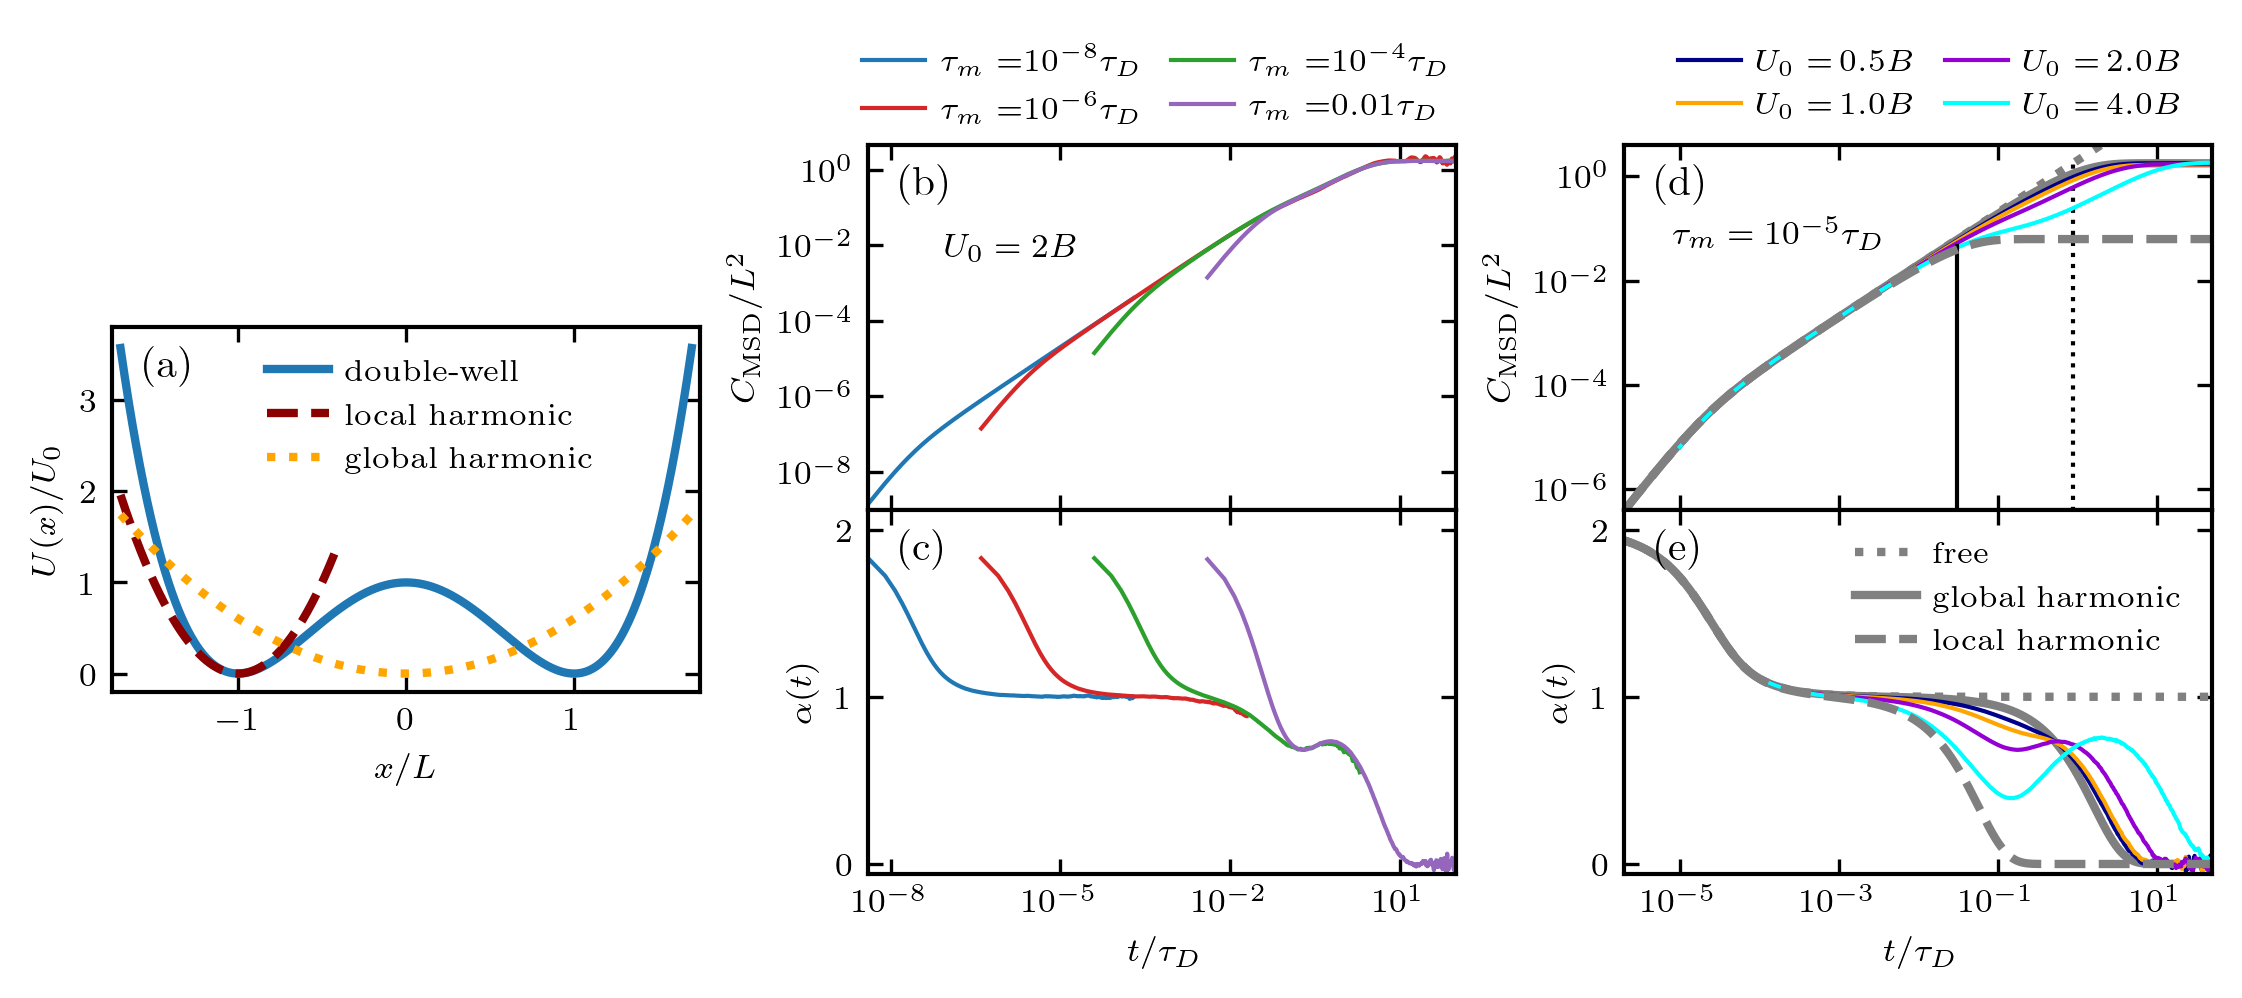

In [16]:
plot_dw_nomem(1e-5, [1e-08, 1e-06, 1e-04, 0.01], [0.5, 1.0, 2.0, 4.0], T=300)
# plt.savefig('fig_msd_dw_nomem.png', bbox_inches='tight')

plt.show()

# Fig. 6

In [19]:
@mpltex.aps_decorator
def plot_dw_mem(u0ldw, tm1, tau_scaling, c, d1, d2, dt=100.0, T=300, iterative=5):
    fig, ax = plt.subplots(2, 2, dpi=300, figsize=(6, 2.7))
    colors = ['darkblue', 'orange', 'darkviolet', 'cyan']


    ax[1, 0].plot([1e-6, 100], [np.log(c/d1)/np.log(c), np.log(c/d1)/np.log(c)], c='k', lw=2)
    ax[1, 1].plot([1e-6, 100], [np.log(c/d2)/np.log(c), np.log(c/d2)/np.log(c)], c='k', lw=2)

    dt = 100.0

    taud = 1
    L = 1
    kT = 2.49 *(T/300)
    mfpt = [0]
    taum = tm1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud
    #K = kT / (m * L**2) # K such that at x=1 energy is kT
    i=0

    pos = np.linspace(-1-1, 0, int(100 * (1+1)/2))
    pos = np.unique(np.append(pos, np.linspace(0, 2, 100)))
    Ull = np.min(u0ldw)*kT
    fel = Ull * ((pos[np.where(pos<0)] / 1)**2 - 1)**2
    fer = Ull * ((pos[np.where(pos>=0)])**2 - 1)**2
    fe = np.append(fel, fer)
    prob = np.exp(-fe/kT)/ (np.sum(np.exp(-fe/kT))*(pos[1]-pos[0]))
    mu = np.sum(pos * prob) * (pos[1]-pos[0])
    varsq = np.sum((pos-mu)**2 * prob)*(pos[1]-pos[0]) 
    

    ################################################################################################################################
    
    j = 0
    taum = tm1
    t = np.logspace(np.log10(100*taum), np.log10(taum * 1e9 * dt *0.2), 1000)
    taud = 1
    L = 1
    m = taum * taud * kT / L**2
    K = kT / varsq / m
    K2 = 8 * max(u0ldw) * kT / L**2 / m # local approximation by harmonic with Taylor
    B = L**2 / taum / taud
    gammas = np.array([1, d1, d1**2])
    gammas = gammas / np.sum(gammas) * kT
    taus = np.array([1, c, c**2]) * tau_scaling
    amps = gammas / m / taus
    msd_theo1 = msd_tri_expo_harm(*amps,  *taus, K2,  B, t) / L**2
    msd_theo = msd_tri_expo_harm(*amps,  *taus, K,  B, t) / L**2

    msd_theo_free = msd_tri_expo(*amps,  *taus,  B, t) / L**2 #np.sum(gammas)**2 / m**2 / B
    ax[0, 0].plot(t, msd_theo_free, c='grey', lw=2, ls=':', label=r'$\rm{free}$')
    alpha = np.diff(np.log(msd_theo_free))/np.diff(np.log(t))
    ax[1, 0].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], c='grey', lw=2, ls=':')
    

    ax[0, 0].plot(t, msd_theo, c='grey', lw=2, ls='-', label=r'$\rm{global}$ $\rm{harmonic}$')
    alpha = np.diff(np.log(msd_theo))/np.diff(np.log(t))
    ax[1, 0].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], c='grey', lw=2, ls='-')#U(x)=K_{\rm{glob}}x^2/2
    ax[0, 0].plot([np.sum(gammas)/K2/m, np.sum(gammas)/K2/m], [np.min(msd_theo1), 1.5*kT/K2/m], c='k') #2*kT/k but we want to plot lower, thus 1.5*kT/k
    time_scale = np.sum(gammas)/K2/m
    for i in range(iterative):
        time_scale = int_kernel_exp(time_scale, amps, taus)/K2

    ax[0, 0].plot([time_scale, time_scale], [np.min(msd_theo1), 1.5*kT/K2/m], c='k', ls='--')

    time_scale = np.sum(gammas)/K/m
    for i in range(iterative):
        time_scale = int_kernel_exp(time_scale, amps, taus)/K

    ax[0, 0].plot([time_scale, time_scale], [np.min(msd_theo), np.max(msd_theo)], c='k', ls=':')

    # estimate time dependent friction to obtain deviation from local harmonic well approximation
    ax[0, 0].plot(t, msd_theo1, c='grey', lw=2, ls='--', label=r'$\rm{local}$ $\rm{harmonic}$')
    alpha = np.diff(np.log(msd_theo1))/np.diff(np.log(t))
    ax[1, 0].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], c='grey', lw=2, ls='--') #U(x)=K_{\rm{loc}}x^2/2
    for Urr in u0ldw:
        msd = np.load('./msd/msd_av1000_dw_c' + str(c) + '_d' + str(d1) + '_sc' + str(tau_scaling)
                        + '_tm' + str(taum) + '_U0' + str(Urr) + '_ll' + str(1) + '_n1e' + str(int(np.log10(1e8)))
                        + '_dt' + str(dt) + '.npy')[:, :-5] 

 
        ax[0, 0].plot(msd[1,:]*taum, msd[0,:], color=colors[j])#, label=r'$U_0=$' + '$\,'+str(Urr) + '$' +r'$k_BT / m$'

        alpha = np.diff(np.log(msd[0,:]))/np.diff(np.log(taum*msd[1,:]))
        ax[1, 0].plot(msd[1,np.where(msd[1,:-1]*taum < 500e5*taum*dt)[0]]*taum, alpha[np.where(msd[1,:-1]*taum < 500e5*taum*dt)], color=colors[j], label=r'$U_0=$' + '$\,'+str(Urr) + '$' +r'$B$')
        j += 1

    j = 0
    taum = tm1
    taud = 1
    L = 1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud
    gammas = np.array([1, d2, d2**2])
    gammas = gammas / np.sum(gammas) * kT
    taus = np.array([1, c, c**2]) * tau_scaling
    amps = gammas / m / taus
    
    msd_theo1 = msd_tri_expo_harm(*amps,  *taus, K2,  B, t) / L**2
    msd_theo = msd_tri_expo_harm(*amps,  *taus, K,  B, t) / L**2

    msd_theo_free = msd_tri_expo(*amps,  *taus,  B, t) / L**2 #np.sum(gammas)**2 / m**2 / B

    ax[0, 1].plot(t, msd_theo_free, c='grey', lw=2, ls=':')
    alpha = np.diff(np.log(msd_theo_free))/np.diff(np.log(t))
    ax[1, 1].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], c='grey', lw=2, ls=':')
    

    ax[0, 1].plot(t, msd_theo, c='grey', lw=2, ls='-')
    alpha = np.diff(np.log(msd_theo))/np.diff(np.log(t))
    ax[1, 1].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], c='grey', lw=2, ls='-')
    ax[0, 1].plot([np.sum(gammas)/K2/m, np.sum(gammas)/K2/m], [np.min(msd_theo1), 1.5*kT/K2/m], c='k') #msd is 2*kT/k but we want to plot lower #/np.sqrt(d2)
    # estimate time dependent friction to obtain deviation from local harmonic well approximation
    time_scale = np.sum(gammas)/K2/m
    for i in range(iterative):
        time_scale = int_kernel_exp(time_scale, amps, taus)/K2

    ax[0, 1].plot([time_scale, time_scale], [np.min(msd_theo1), 1.5*kT/K2/m], c='k', ls='--')

    time_scale = np.sum(gammas)/K/m
    for i in range(iterative):
        time_scale = int_kernel_exp(time_scale, amps, taus)/K

    ax[0, 1].plot([time_scale, time_scale], [np.min(msd_theo), np.max(msd_theo)], c='k', ls=':')

    ax[0, 1].plot(t, msd_theo1, c='grey', lw=2, ls='--')
    alpha = np.diff(np.log(msd_theo1))/np.diff(np.log(t))
    ax[1, 1].plot(t[np.where(t[:-1] < 500e5*taum*dt)[0]], alpha[np.where(t[:-1] < 500e5*taum*dt)[0]], c='grey', lw=2, ls='--')

    for Urr in u0ldw:
        msd = np.load('./msd/msd_av1000_dw_c' + str(c) + '_d' + str(d2) + '_sc' + str(tau_scaling)
                        + '_tm' + str(taum) + '_U0' + str(Urr) + '_ll' + str(1) + '_n1e' + str(int(np.log10(1e8)))
                        + '_dt' + str(dt) + '.npy')[:, :-5]
#/net/data04/kanton/double_well

        ax[0, 1].plot(msd[1,:] * taum, msd[0,:], color=colors[j], label=r'$U_0=$' + '$\,'+str(Urr) + '$' +r'$B$')

        alpha = np.diff(np.log(msd[0,:]))/np.diff(np.log(taum*msd[1,:]))
        ax[1, 1].plot(msd[1,np.where(taum*msd[1,:-1] < 500e5*taum*dt)[0]] * taum, alpha[np.where(taum*msd[1,:-1] < 500e5*taum*dt)], color=colors[j], label=r'$U_0=$' + '$\,'+str(Urr) + '$' +r'$B$')
        j += 1

    ######################################################################################################################################


    ######################################################################################################################################

    ax[0, 0].loglog()
    ax[0, 1].loglog()
    ax[1, 0].semilogx()
    ax[1, 0].semilogx()
    ax[1, 1].semilogx()

    ax[0, 0].set_ylabel(r'$C_{\rm{MSD}}/L^2$')
    ax[1, 0].set_ylabel(r'$\alpha(t)$')
    ax[0, 1].set_ylabel(r'$C_{\rm{MSD}}/L^2$')
    ax[1, 1].set_ylabel(r'$\alpha(t)$')
    
    ax[1, 0].set_xlabel(r'$t/\tau_D$')
    ax[1, 1].set_xlabel(r'$t/\tau_D$')

    ax[1, 0].legend(loc='upper left', frameon=False, bbox_to_anchor=[-0.8, 1.75])
    ax[0, 0].legend(loc='upper left', frameon=False, bbox_to_anchor=[-0.8, -0.05])

    ax[0, 0].set_xticklabels([])
    ax[0, 1].set_xticklabels([])

    ax[0, 0].set_yticks([1e-3, 0.01, 0.1, 1])
    ax[0, 1].set_yticks([1e-3, 0.01, 0.1, 1])
    ax[1, 0].set_yticks([0, 1, 2])
    ax[1, 1].set_yticks([0, 1, 2])

    ax[0, 0].tick_params(axis='x', direction='in')
    ax[0, 1].tick_params(axis='x', direction='in')
    ax[1, 0].tick_params(axis='y', direction='in')
    ax[1, 1].tick_params(axis='y', direction='in')

    ax[1, 0].set_ylim(-0.45, 2.06)
    ax[1, 0].set_ylim(-0.45, 2.06)
    ax[1, 1].set_ylim(-0.45, 2.06)

    ax[0, 0].set_ylim(1e-4, 4)
    ax[0, 1].set_ylim(1e-4, 4)

    ax[0, 0].set_xlim(2e-6, 50)
    ax[1, 0].set_xlim(2e-6, 50)

    ax[0, 0].set_xlim(1.1e-6, 50)
    ax[1, 0].set_xlim(1.1e-6, 50)

    ax[0, 1].set_xlim(1.1e-6, 50)
    ax[1, 1].set_xlim(1.1e-6, 50)

    ax[0, 0].set_xticks([1e-5, 1e-3, 1e-1, 10])
    ax[1, 0].set_xticks([1e-5, 1e-3, 1e-1, 10])
    ax[0, 1].set_xticks([1e-5, 1e-3, 1e-1, 10])
    ax[1, 1].set_xticks([1e-5, 1e-3, 1e-1, 10])

    ax[0, 0].set_title(r'$c=100$, $d=5$')
    ax[0, 1].set_title(r'$c=100$, $d=20$')

    subplotlabels = [r'$\rm{(a)}$', r'$\rm{(b)}$', r'$\rm{(c)}$', r'$\rm{(d)}$']
    axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(0.105, -8/72, fig.dpi_scale_trans)
       axes[i].text(0.0, 1.0, subplotlabel, fontsize=10, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))

    plt.subplots_adjust(wspace=0.3, hspace=0.0)



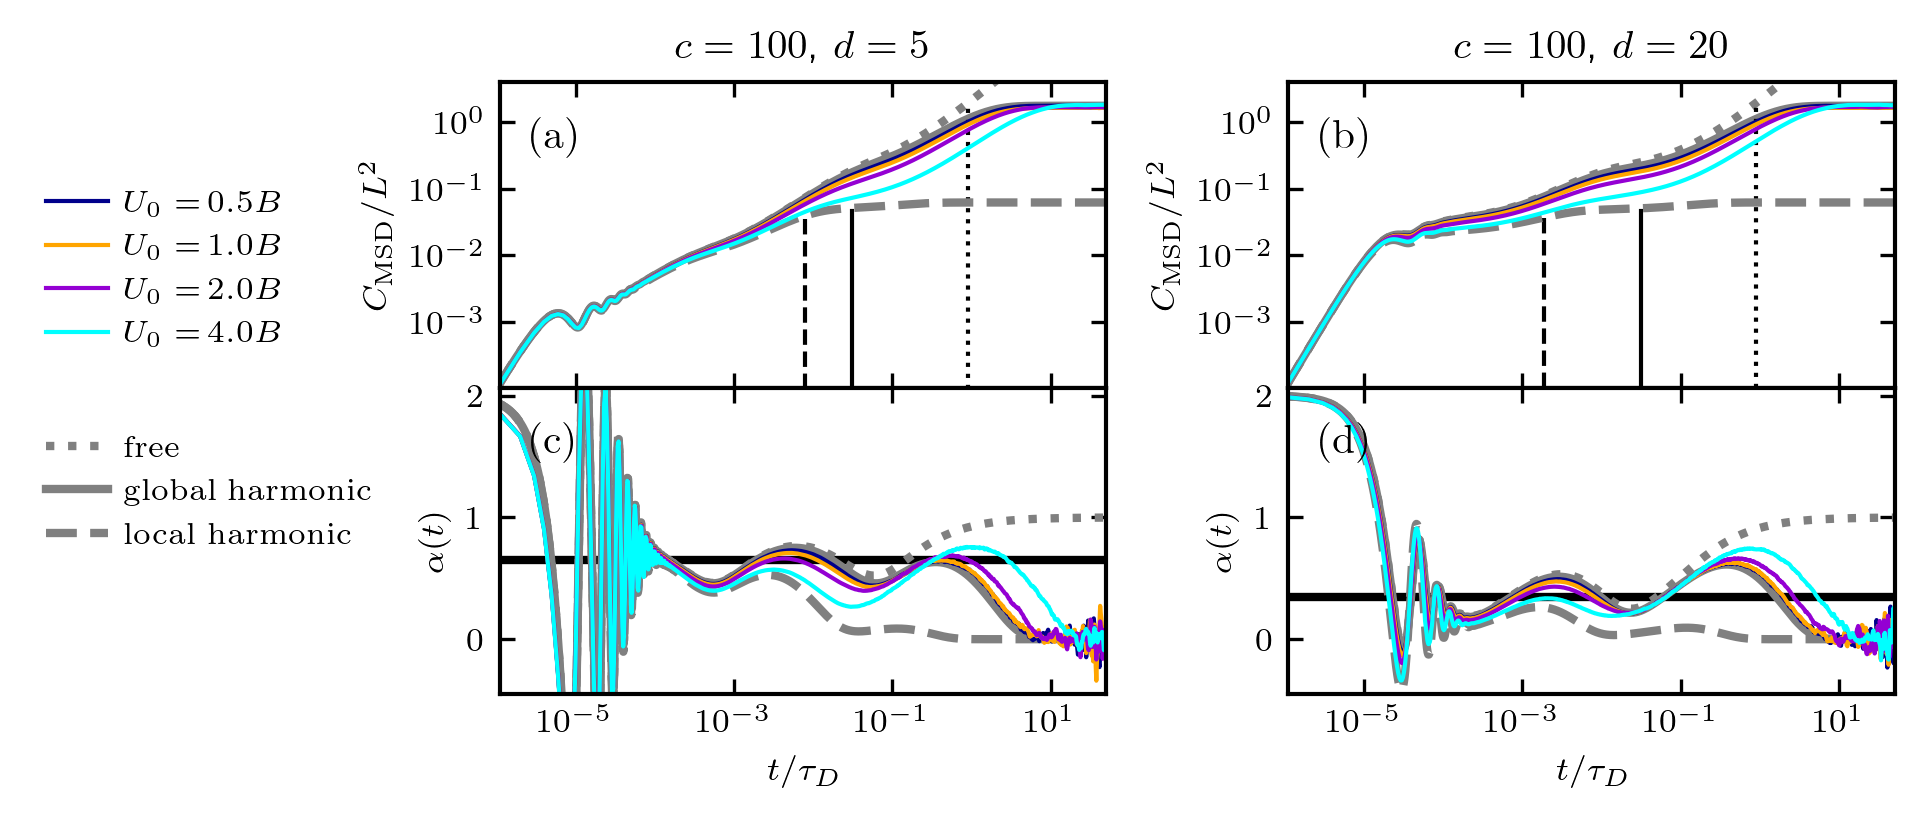

In [20]:
plot_dw_mem([0.5, 1.0, 2.0, 4.0], 1e-8, 1e-5, 100.0, 5.0, 20.0, dt=100.0, iterative=10000)
# plt.savefig('fig_msd_dw_mem.png', bbox_inches='tight')

plt.show()

# SI Figures

# Fig. S1

/tmp/ipykernel_4094316/3700234897.py:17: RuntimeWarning: invalid value encountered in log
  ax.plot(d_list, (-np.log(d_list / c_list[j]) + np.log(1-(d_list / c_list[j])**(n)) - np.log(1-(d_list / c_list[j])**(n-1))) / np.log(c_list[j]), c='k', ls=':', lw=2) #for i=1 value between tau1 and tau2
/tmp/ipykernel_4094316/3700234897.py:17: RuntimeWarning: invalid value encountered in log
  ax.plot(d_list, (-np.log(d_list / c_list[j]) + np.log(1-(d_list / c_list[j])**(n)) - np.log(1-(d_list / c_list[j])**(n-1))) / np.log(c_list[j]), c='k', ls=':', lw=2) #for i=1 value between tau1 and tau2
/tmp/ipykernel_4094316/3700234897.py:17: RuntimeWarning: invalid value encountered in log
  ax.plot(d_list, (-np.log(d_list / c_list[j]) + np.log(1-(d_list / c_list[j])**(n)) - np.log(1-(d_list / c_list[j])**(n-1))) / np.log(c_list[j]), c='k', ls=':', lw=2) #for i=1 value between tau1 and tau2
/tmp/ipykernel_4094316/3700234897.py:17: RuntimeWarning: divide by zero encountered in log
  ax.plot(d_list, (-np.l

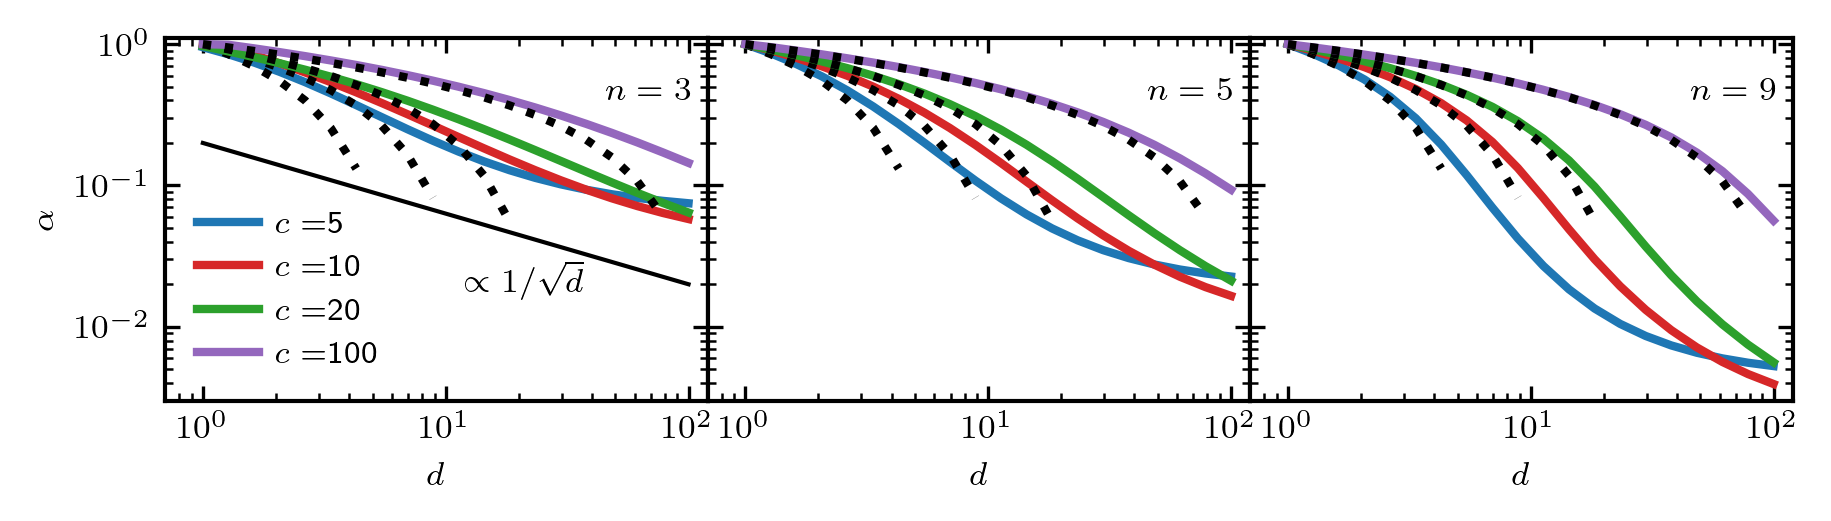

In [21]:
@mpltex.aps_decorator
def alpha_cd_plot_diffn(c_list, d_list, n_list, tau0=1):
    fig, axis = plt.subplots(1, len(n_list), dpi=300, figsize=(7, 1.6))
    for n_ind in range(len(n_list)):
        alpha_d_c_n5 = np.zeros((len(c_list), len(d_list)))
        ax = axis[n_ind]
        x0 = np.array([0.5, 1.0])
        for i, d_in in enumerate(d_list):
            for j, c_in in enumerate(c_list):
                tarr = np.logspace(np.log10(tau0), np.log10(tau0* c_in**(n_list[n_ind] - 1)) - 1, 1000)
                res = least_squares(lambda x: sigma_kerns_alpha(x, tarr, c_in, d_in, n_list[n_ind], tau0), x0, bounds=([0, 0], [1, np.inf]))
                alpha_d_c_n5[j, i] = res.x[0]


        for j in range(len(c_list)):
            ax.plot(d_list, alpha_d_c_n5[j, :], label=r'$c=$' + str(c_list[j]), lw=2)
            ax.plot(d_list, (-np.log(d_list / c_list[j]) + np.log(1-(d_list / c_list[j])**(n)) - np.log(1-(d_list / c_list[j])**(n-1))) / np.log(c_list[j]), c='k', ls=':', lw=2) #for i=1 value between tau1 and tau2

        ax.text(0.81, 0.83, r'$n=' + str(int(n_list[n_ind])) + '$', transform=ax.transAxes)
        ax.loglog()
        ax.set_xlabel(r'$d$')
        
        
        ax.set_ylim(0.003, 1.1)
        ax.set_yticks([0.01, 0.1, 1])
        ax.set_ylim(0.003, 1.1)
        ax.set_xlim(0.7, 120)
        ax.set_xticks([1, 10, 100])
        if n_ind > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$\alpha$')
            ax.legend(loc='lower left')
            ax.plot(d_list, 0.2/np.sqrt(d_list), c='k')
            ax.text(0.55, 0.3, r'$\propto 1/\sqrt{d}$', transform=ax.transAxes)
    plt.subplots_adjust(wspace=0)
    # plt.savefig('fig_alpha_d_diffn.png', bbox_inches='tight')

c_list = [5, 10, 20, 100]
d_list = np.logspace(0, 2, 20)
n_list = [3, 5, 9]
alpha_cd_plot_diffn(c_list, d_list, n_list, tau0=1)
plt.show()

# Fig. S2

In [22]:
@mpltex.aps_decorator
def msd_alpha_n3(tau_m, tau_scaling, n_iterate=100):
    fig, ax = plt.subplots(2, 4, sharex=True, dpi=300, figsize=(7, 2.7))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    ax[1, 0].set_yticks([0, 1, 2])
    ax[1, 1].set_yticks([0, 1, 2])
    ax[1, 2].set_yticks([0, 1, 2])
    ax[1, 3].set_yticks([0, 1, 2])

    ax[1, 0].set_xticks([1, 1e2, 1e4, 1e6])
    ax[1, 1].set_xticks([1, 1e2, 1e4, 1e6])
    ax[1, 2].set_xticks([1, 1e2, 1e4, 1e6])
    ax[1, 3].set_xticks([1, 1e2, 1e4, 1e6])

    ax[1, 0].tick_params('x', top=True)
    ax[1, 1].tick_params('x', top=True)
    ax[1, 2].tick_params('x', top=True)
    ax[1, 3].tick_params('x', top=True)

    taud = 1
    taum = tau_m * taud
    L = 1
    kT = 1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud

    ax[0, 0].set_title(r'$c = 0.1$')

    gamma = np.array([1, 0.1, 0.01])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d01_lim = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 0].plot(t*np.sum(gamma)/m, msdc01d01_lim, label=r'$d=0.1$')

    gamma = np.array([1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d1 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 0].plot(t*np.sum(gamma)/m, msdc01d1, label=r'$d=1$', ls='-')


    gamma = np.array([1, 2, 4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d2 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 0].plot(t*np.sum(gamma)/m, msdc01d2, label=r'$d=2$', ls='-')

    gamma = np.array([1, 5, 25])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d5 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 0].plot(t*np.sum(gamma)/m, msdc01d5, label=r'$d=5$', ls='-')

    gamma = np.array([1, 10, 100])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d10 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 0].plot(t*np.sum(gamma)/m, msdc01d10, label=r'$d=10$', ls='-')

    gamma = np.array([1, 100, 10000])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d100 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B

    ax[0, 0].set_xlabel(r'$t/\tau_{m}$')
    ax[0, 0].set_ylabel(r'$C_{\rm{MSD}} /(B \tau_{m}^2)$') #\langle v^2 \rangle
    ax[0, 0].loglog()

    ax[0, 0].plot(t[370:1450]*np.sum(gamma)/m, 0.3*(t[370:1450]*np.sum(gamma)/m)**2, c='k')
    ax[0, 0].plot(t[6000:8000]*np.sum(gamma)/m, 0.5*t[6000:8000]*np.sum(gamma)/m, c='k')

    ax[0, 0].text(0.85, 0.05, r'$\propto t^2$')
    ax[0, 0].text(2.7e4, 4e3, r'$\propto t$')


    ax[0, 1].set_title(r'$c = 5$')

    gamma = np.array([1, 0.1, 0.01])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])

    amps = gamma / m / tau 
    msdc5d01 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 1].plot(t*np.sum(gamma)/m, msdc5d01, label=r'$d=0.1$')

    gamma = np.array([1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d1 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 1].plot(t*np.sum(gamma)/m, msdc5d1, label=r'$d=1$', ls='-')


    gamma = np.array([1, 2, 4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d2 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 1].plot(t*np.sum(gamma)/m, msdc5d2, label=r'$d=2$', ls='-')

    gamma = np.array([1, 5, 25])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d5 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 1].plot(t*np.sum(gamma)/m, msdc5d5, label=r'$d=5$', ls='-')

    gamma = np.array([1, 10, 100])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d10 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 1].plot(t*np.sum(gamma)/m, msdc5d10, label=r'$d=10$', ls='-')

    gamma = np.array([1, 100, 10000])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d100 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B

    ax[0, 1].set_xlabel(r'$t/\tau_{m}$')
    ax[0, 1].loglog()



    ax[0, 2].set_title(r'$c = 10$')

    gamma = np.array([1, 0.1, 0.01])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])

    amps = gamma / m / tau 
    msdc10d01 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 2].plot(t*np.sum(gamma)/m, msdc10d01, label=r'$d=0.1$')


    gamma = np.array([1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d1 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 2].plot(t*np.sum(gamma)/m, msdc10d1, label=r'$d=1$', ls='-')

    gamma = np.array([1, 2, 4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d2 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 2].plot(t*np.sum(gamma)/m, msdc10d2, label=r'$d=2$', ls='-')

    gamma = np.array([1, 5, 25])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d5 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 2].plot(t*np.sum(gamma)/m, msdc10d5, label=r'$d=5$', ls='-')

    gamma = np.array([1, 10, 100])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d10 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 2].plot(t*np.sum(gamma)/m, msdc10d10, label=r'$d=10$', ls='-')


    gamma = np.array([1, 100, 10000])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d100 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B

    ax[0, 2].set_xlabel(r'$t/\tau_{m}$')
    ax[0, 2].loglog()



    ax[0, 3].set_title(r'$c = 100$')

    gamma = np.array([1, 0.1, 0.01])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])

    amps = gamma / m / tau 
    msdc100d01 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 3].plot(t*np.sum(gamma)/m, msdc100d01, label=r'$d=0.1$')

    time_scale = m / np.sum(gamma)
    for i in range(n_iterate):
        time_scale = m / int_kernel_exp(time_scale, amps, tau)

    ax[0, 3].plot([time_scale, time_scale], [np.min(msdc100d01), 0.45], c=colors[0], ls='-', lw=2)


    gamma = np.array([1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d1 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 3].plot(t*np.sum(gamma)/m, msdc100d1, label=r'$d=1$', ls='-')


    gamma = np.array([1, 2, 4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d2 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 3].plot(t*np.sum(gamma)/m, msdc100d2, label=r'$d=2$', ls='-')

    gamma = np.array([1, 5, 25])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d5 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 3].plot(t*np.sum(gamma)/m, msdc100d5, label=r'$d=5$', ls='-')

    # time_scale = m / np.sum(gamma)
    # for i in range(n_iterate):
    #     time_scale = m / int_kernel_exp(time_scale, amps, tau)

    # ax[0, 3].plot([time_scale, time_scale], [np.min(msdc100d5), 1], c=colors[3], ls='-', lw=2)

    gamma = np.array([1, 10, 100])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d10 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[0, 3].plot(t*np.sum(gamma)/m, msdc100d10, label=r'$d=10$', ls='-')

    time_scale = m / np.sum(gamma)
    for i in range(n_iterate):
        time_scale = m / int_kernel_exp(time_scale, amps, tau)

    ax[0, 3].plot([time_scale, time_scale], [2e3, np.max(msdc100d10)], c=colors[4], ls='-', lw=2)


    ax[0, 3].legend(loc='lower right', bbox_to_anchor=[1.6, -0.4])
    ax[0, 3].set_xlabel(r'$t/\tau_{m}$')
    # ax[0, 3].set_ylabel(r'$C_{\rm{MSD}} /(B \tau_{m}^2)$')
    ax[0, 3].loglog()



    taud = 1
    taum = tau_m * taud
    L = 1
    kT = 1
    m = taum * taud * kT / L**2
    B = L**2 / taum / taud


    gamma = np.array([1, 0.1, 0.01])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d01 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    msdc01d01 = np.diff(np.log(msdc01d01))/np.diff(np.log(t*np.sum(gamma)/m))
    ax[1, 0].plot(t[:-1]*np.sum(gamma)/m, msdc01d01, label=r'$d=0.1$')

    gamma = np.array([1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d1 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 0].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc01d1)) / np.diff(np.log(t)), label=r'$d=1$', ls='-')


    gamma = np.array([1, 2, 4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d2 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 0].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc01d2)) / np.diff(np.log(t)), label=r'$d=2$', ls='-')

    gamma = np.array([1, 5, 25])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d5 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 0].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc01d5)) / np.diff(np.log(t)), label=r'$d=5$', ls='-')

    gamma = np.array([1, 10, 100])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d10 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 0].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc01d10)) / np.diff(np.log(t)), label=r'$d=10$', ls='-')

    gamma = np.array([1, 100, 10000])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 0.1, 0.01])
    amps = gamma / m / tau 
    msdc01d100 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B

    ax[1, 0].set_xlabel(r'$t/\tau_{m}$')
    ax[1, 0].set_ylabel(r'$\alpha (t)$')
    ax[1, 0].semilogx()



    gamma = np.array([1, 0.1, 0.01])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])

    amps = gamma / m / tau 
    msdc5d01 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 1].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc5d01)) / np.diff(np.log(t)), label=r'$d=0.1$')

    gamma = np.array([1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d1 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 1].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc5d1)) / np.diff(np.log(t)), label=r'$d=1$', ls='-')

    gamma = np.array([1, 2, 4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d2 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 1].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc5d2)) / np.diff(np.log(t)), label=r'$d=2$', ls='-')

    gamma = np.array([1, 5, 25])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d5 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    t_ind = np.append(np.where(t[:-1]*np.sum(gamma)/m < 1e2)[0], np.where(t[:-1]*np.sum(gamma)/m > 2e3)[0])
    alpha = np.diff(np.log(msdc5d5)) / np.diff(np.log(t))
    ax[1, 1].plot(t[t_ind]*np.sum(gamma)/m, alpha[t_ind], label=r'$d=5$', ls='-')

    gamma = np.array([1, 10, 100])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d10 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    t_ind = np.append(np.where(t[:-1]*np.sum(gamma)/m < 2e2)[0], np.where(t[:-1]*np.sum(gamma)/m > 1e4)[0])
    alpha = np.diff(np.log(msdc5d10)) / np.diff(np.log(t))
    ax[1, 1].plot(t[t_ind]*np.sum(gamma)/m, alpha[t_ind], label=r'$d=10$', ls='-')

    gamma = np.array([1, 100, 10000])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 5, 25])
    amps = gamma / m / tau 
    msdc5d100 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B

    ax[1, 1].set_xlabel(r'$t/\tau_{m}$')
    ax[1, 1].semilogx()




    gamma = np.array([1, 0.1, 0.01])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])

    amps = gamma / m / tau 
    msdc10d01 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 2].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc10d01)) / np.diff(np.log(t)), label=r'$d=0.1$')

    gamma = np.array([1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d1 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 2].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc10d1)) / np.diff(np.log(t)), label=r'$d=1$', ls='-')


    gamma = np.array([1, 2, 4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d2 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 2].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc10d2)) / np.diff(np.log(t)), label=r'$d=2$', ls='-')

    gamma = np.array([1, 5, 25])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d5 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 2].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc10d5)) / np.diff(np.log(t)), label=r'$d=5$', ls='-')

    gamma = np.array([1, 10, 100])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d10 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    t_ind = np.append(np.where(t[:-1]*np.sum(gamma)/m < 3e2)[0], np.where(t[:-1]*np.sum(gamma)/m > 1e4)[0])
    alpha = np.diff(np.log(msdc10d10)) / np.diff(np.log(t))
    ax[1, 2].plot(t[t_ind]*np.sum(gamma)/m, alpha[t_ind], label=r'$d=10$', ls='-')

    gamma = np.array([1, 100, 10000])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 10, 100])
    amps = gamma / m / tau 
    msdc10d100 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B

    ax[1, 2].set_xlabel(r'$t/\tau_{m}$')
    ax[1, 2].semilogx()




    ax[1, 3].plot([t[0]*np.sum(gamma)/m, 1e7], [np.log(100/2)/np.log(100), np.log(100/2)/np.log(100)], c=colors[2], alpha=0.4, ls='-', lw=2.5)
    ax[1, 3].plot([t[0]*np.sum(gamma)/m, 1e7], [np.log(100/5)/np.log(100), np.log(100/5)/np.log(100)], c=colors[3], alpha=0.4, ls='-', lw=2.5)
    ax[1, 3].plot([t[0]*np.sum(gamma)/m, 1e7], [np.log(100/10)/np.log(100), np.log(100/10)/np.log(100)], c=colors[4], alpha=0.4, ls='-', lw=2.5)


    gamma = np.array([1, 0.1, 0.01])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])

    amps = gamma / m / tau 
    msdc100d01 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 3].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc100d01)) / np.diff(np.log(t)), label=r'$d=0.1$')

    gamma = np.array([1, 1, 1])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d1 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 3].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc100d1)) / np.diff(np.log(t)), label=r'$d=1$', ls='-')

    gamma = np.array([1, 2, 4])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d2 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 3].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc100d2)) / np.diff(np.log(t)), label=r'$d=2$', ls='-')

    gamma = np.array([1, 5, 25])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d5 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 3].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc100d5)) / np.diff(np.log(t)), label=r'$d=5$', ls='-')

    gamma = np.array([1, 10, 100])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d10 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    ax[1, 3].plot(t[:-1]*np.sum(gamma)/m, np.diff(np.log(msdc100d10)) / np.diff(np.log(t)), label=r'$d=10$', ls='-') #ls='-'

    gamma = np.array([1, 100, 10000])
    gamma = gamma / np.sum(gamma)
    t = np.logspace(-1, 7, 10000) / np.sum(gamma) * m
    tau = tau_scaling * np.array([1, 100, 10000])
    amps = gamma / m / tau 
    msdc100d100 = msd_tri_expo(*amps,  *tau,  B, t) * np.sum(gamma)**2 / m**2 / B
    t_ind = np.append(np.where(t[:-1]*np.sum(gamma)/m < 2e4)[0], np.where(t[:-1]*np.sum(gamma)/m > 1e6)[0])
    alpha = np.diff(np.log(msdc100d100)) / np.diff(np.log(t))

    ax[1, 3].set_xlabel(r'$t/\tau_{m}$')
    ax[1, 3].semilogx()

    ax[1, 0].set_ylim(-0.1,2.05)
    ax[1, 1].set_ylim(-0.1,2.05)
    ax[1, 2].set_ylim(-0.1,2.05)
    ax[1, 3].set_ylim(-0.1,2.05)

    ax[1, 1].set_yticklabels([])
    ax[1, 2].set_yticklabels([])
    ax[1, 3].set_yticklabels([])

    ax[0, 1].set_yticklabels([])
    ax[0, 2].set_yticklabels([])
    ax[0, 3].set_yticklabels([])

    ax[1, 0].set_xticks([1, 1e2, 1e4, 1e6])
    ax[1, 1].set_xticks([1, 1e2, 1e4, 1e6])
    ax[1, 2].set_xticks([1, 1e2, 1e4, 1e6])
    ax[1, 3].set_xticks([1, 1e2, 1e4, 1e6])

    ax[0, 0].set_yticks([1, 1e3, 1e6])
    ax[0, 1].set_yticks([1, 1e3, 1e6])
    ax[0, 2].set_yticks([1, 1e3, 1e6])
    ax[0, 3].set_yticks([1, 1e3, 1e6])

    ax[0, 0].set_ylim(np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5)
    ax[0, 1].set_ylim(np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5)
    ax[0, 2].set_ylim(np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5)
    ax[0, 3].set_ylim(np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5)

    ax[0, 3].text(3, 0.1, r'$\tau_p$')
    ax[0, 3].text(50, 1e5, r'$\tau_p$')
    ax[0, 3].text(1.2e4, 1, r'$\tau_{n}$')
    ax[0, 3].vlines(1e4, np.min(msdc01d01_lim)*0.7, np.max(msdc01d01_lim)*1.5, colors='gray', ls='--')
    ax[1, 3].vlines(1e4, -0.1, 2.05, colors='gray', ls='--')

    # subplotlabels = [r'$\rm{A}$', r'$\rm{B}$', r'$\rm{C}$', r'$\rm{D}$']
    subplotlabels = [r'$\rm{(a)}$', r'$\rm{(b)}$', r'$\rm{(c)}$', r'$\rm{(d)}$']
    axes = [ax[0,0], ax[0,1], ax[0,2], ax[0,3]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(0.105, -8/72, fig.dpi_scale_trans)
       axes[i].text(0.0, 1.0, subplotlabel, fontsize=10, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))


    subplotlabels = [r'$\rm{(e)}$', r'$\rm{(f)}$', r'$\rm{(g)}$', r'$\rm{(h)}$']
    axes = [ax[1,0], ax[1,1], ax[1,2], ax[1,3]]
    for i, subplotlabel in enumerate(subplotlabels):
       trans = mtransforms.ScaledTranslation(1.14, -8/72, fig.dpi_scale_trans)
       axes[i].text(0.0, 1.0, subplotlabel, fontsize=10, transform=axes[i].transAxes + trans, va='top',
             bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))

    # plt.subplots_adjust(left=1, bottom=None, right=2.6, top=1, wspace=0, hspace=0)
    plt.subplots_adjust(wspace=0, hspace=0)


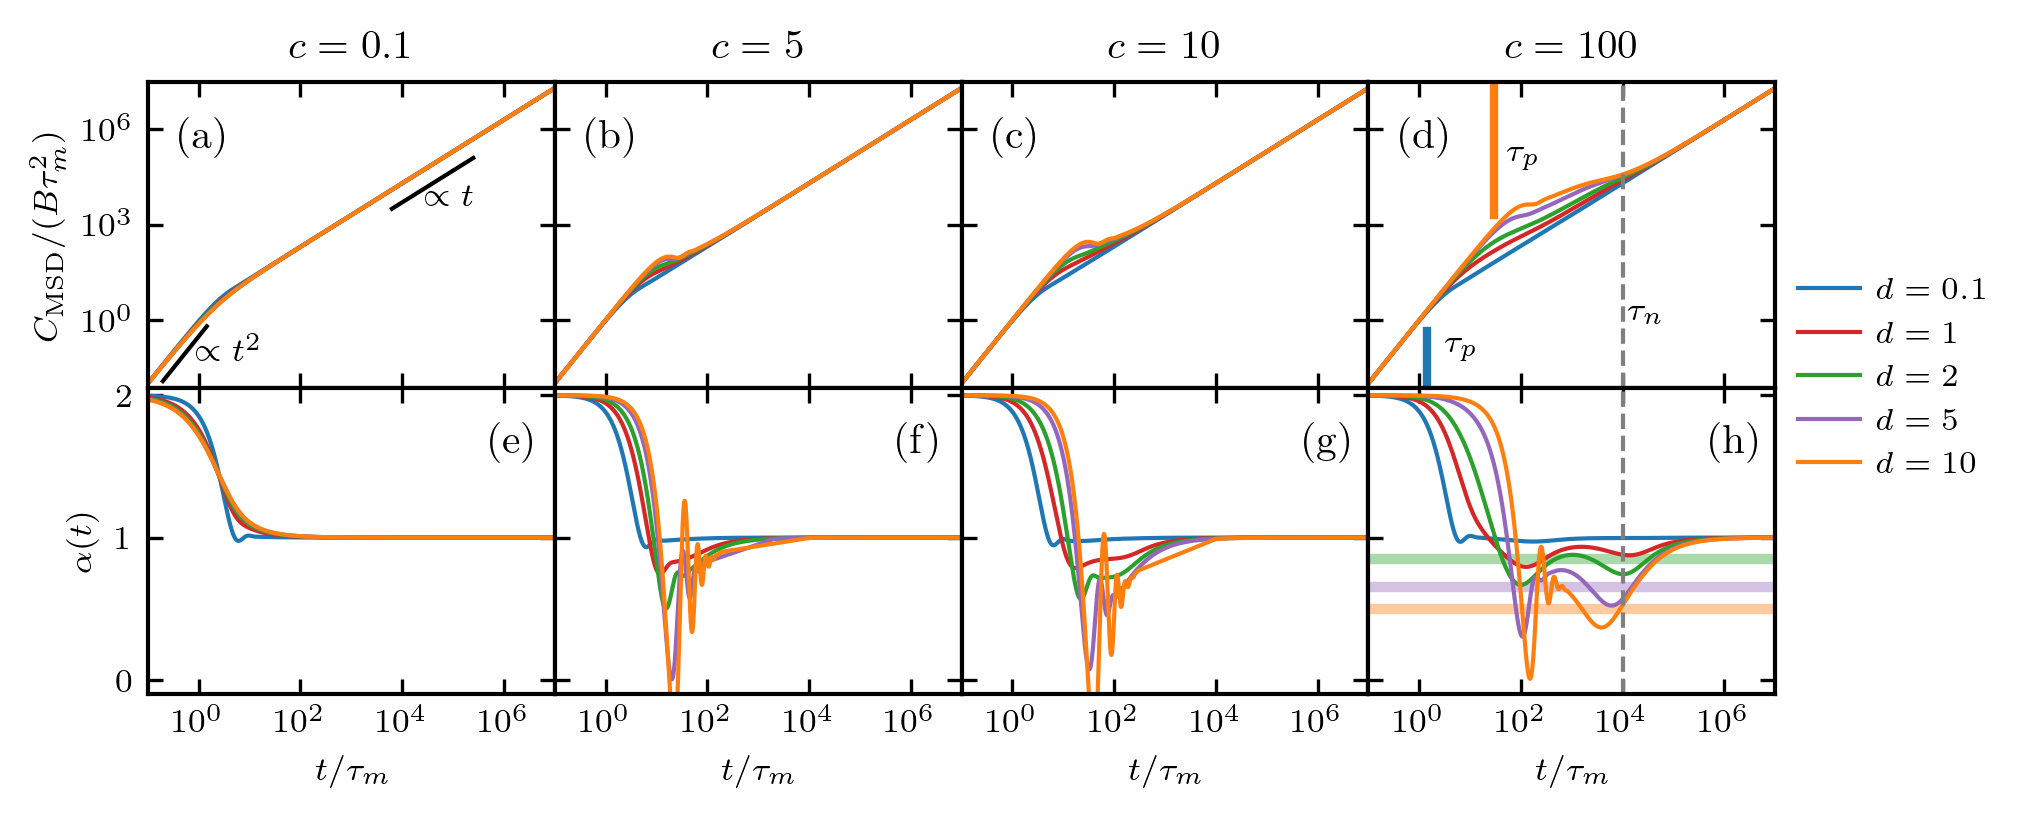

In [23]:
msd_alpha_n3(1, 1, n_iterate=1000)
# plt.savefig('fig_msd_alpha.png', bbox_inches='tight')
plt.show()

# Fig. S3

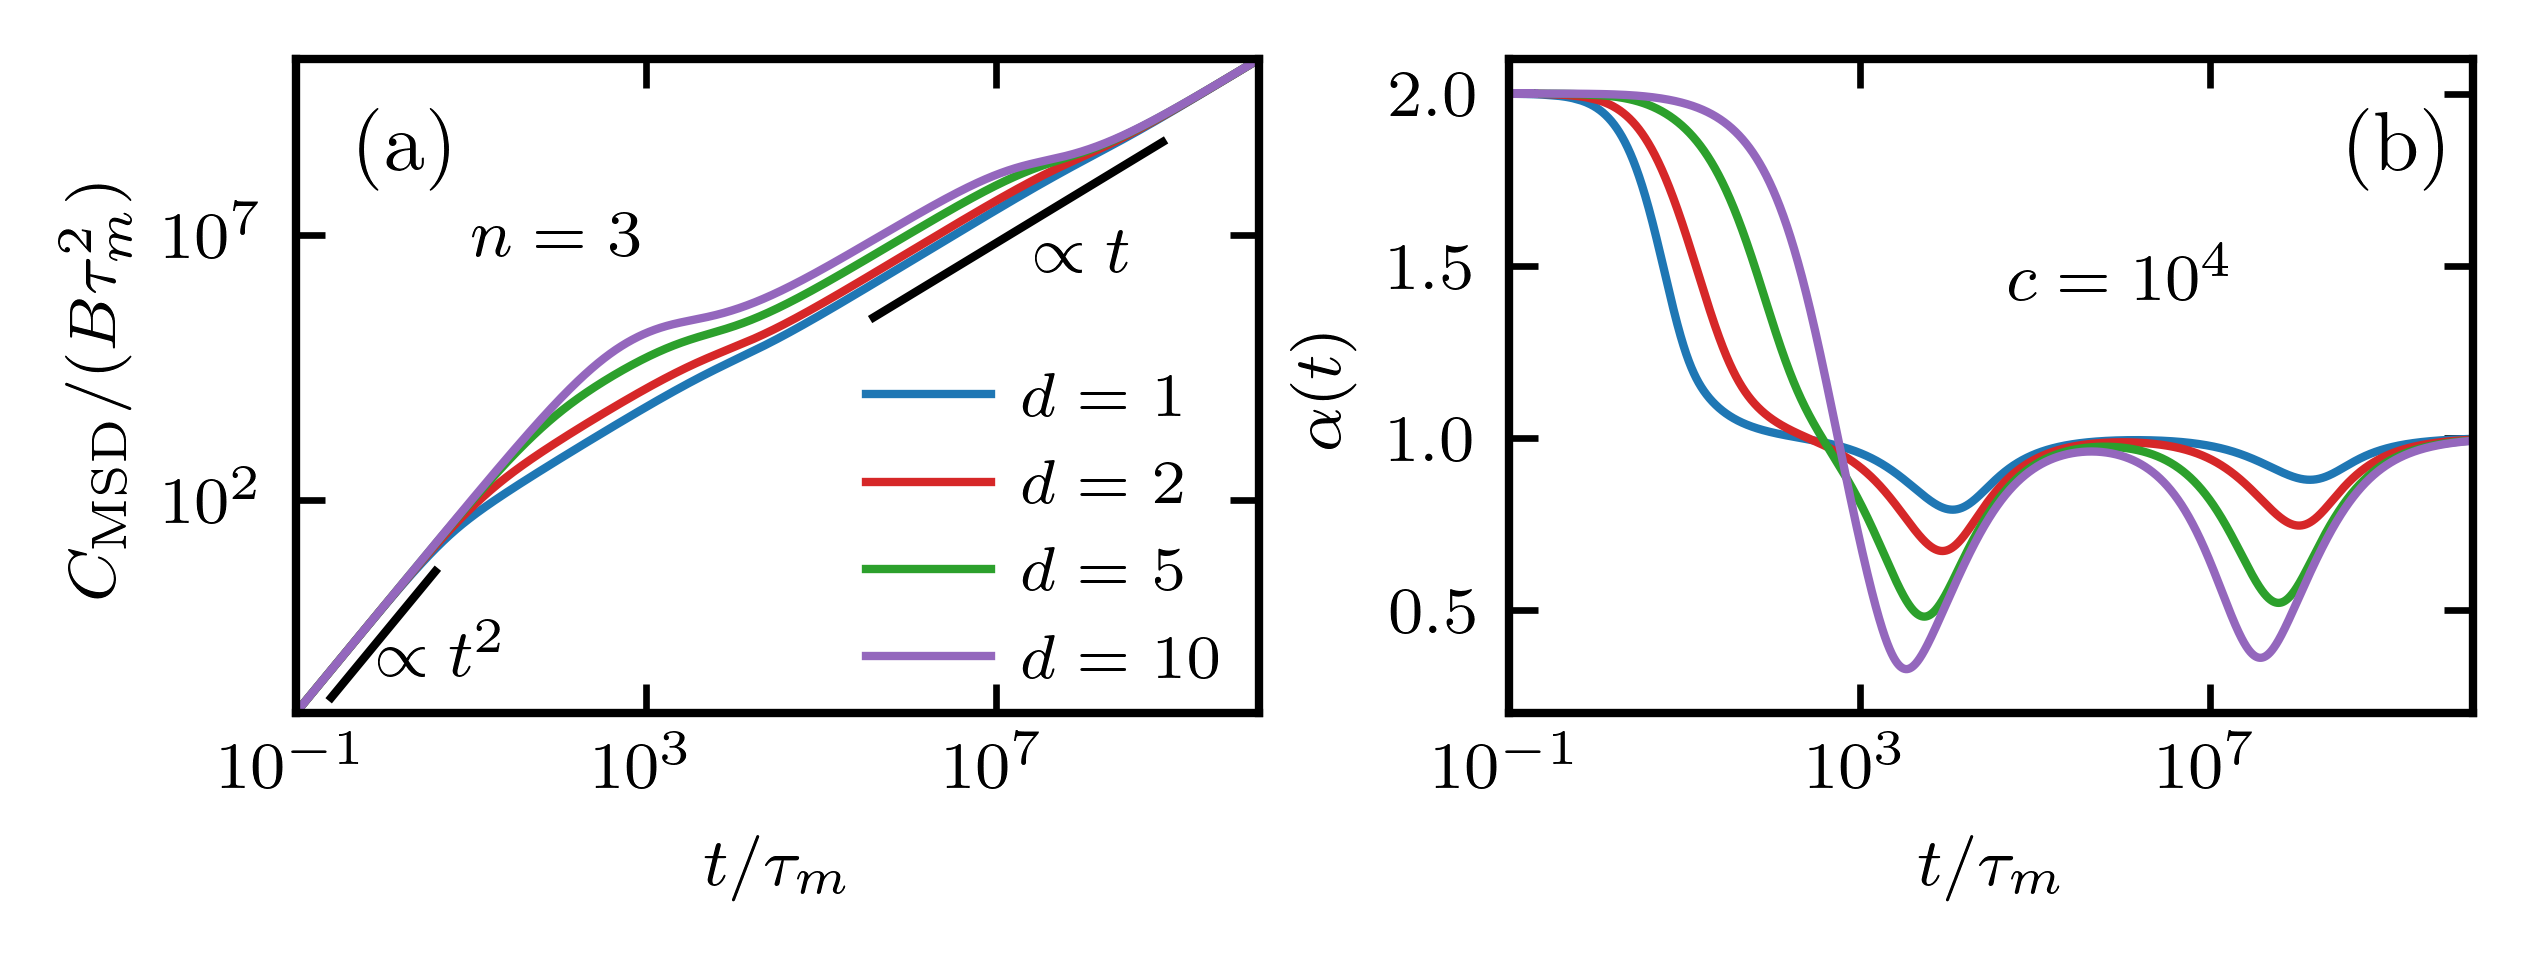

In [24]:
@mpltex.aps_decorator
def bigc_plot():
    fig, ax = plt.subplots(1, 2, dpi=600)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plot_n3_msd(ax[0], [1, 2, 5, 10], 10000, indicate=True)
    ax[0].legend(loc='lower right', bbox_to_anchor=[1.03, -0.06])
    plot_n3_alpha(ax[1], [1, 2, 5, 10], 10000)
    ax[1].set_ylim(0.2, 2.1)
    ax[1].set_yticks([0.5, 1, 1.5, 2])

    trans = mtransforms.ScaledTranslation(0.105, -0.08, fig.dpi_scale_trans)
    ax[0].text(0.0, 1.0, r'$\rm{(a)}$', fontsize=10, transform=ax[0].transAxes + trans, va='top',
            bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))

    trans = mtransforms.ScaledTranslation(1.4, -0.08, fig.dpi_scale_trans)
    ax[1].text(0.0, 1.0, r'$\rm{(b)}$', fontsize=10, transform=ax[1].transAxes + trans, va='top',
            bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))
    
    ax[1].text(5e4, 1.4, r'$c=10^4$')
    ax[0].text(10, 4e6, r'$n=3$')

    
bigc_plot()
plt.subplots_adjust(wspace=0.26, right=1.2, top=0.6)
# plt.savefig('fig_SI_bigc.pdf', bbox_inches='tight')
# plt.savefig('fig_SI_bigc.png', bbox_inches='tight')
plt.show()

# Fig. S4

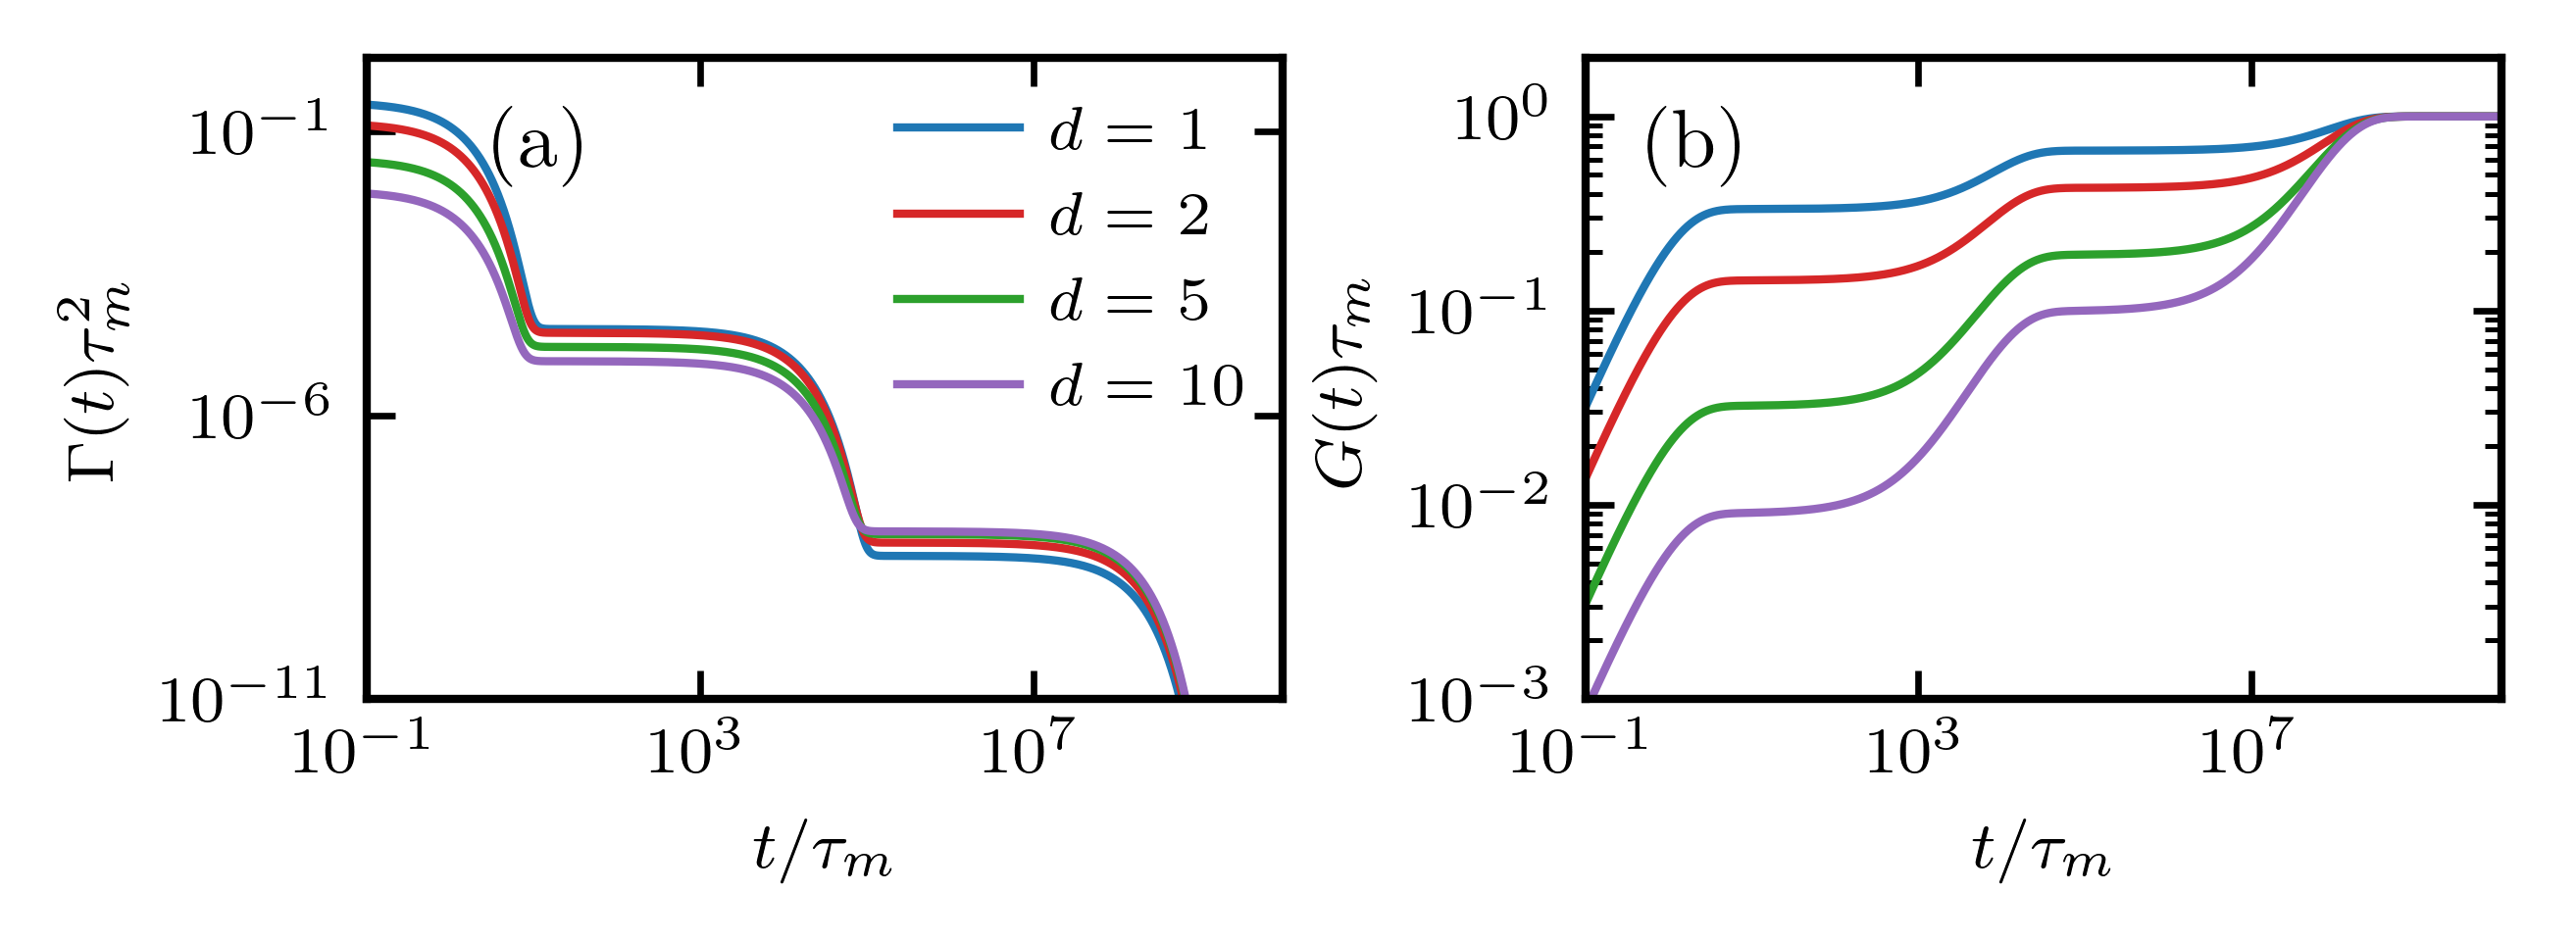

In [25]:
@mpltex.aps_decorator
def bigc_plot_gamma_G():
    fig, ax = plt.subplots(1, 2, dpi=600)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plot_n3_kernel(ax[0], [1, 2, 5, 10], 10000)
    ax[0].legend(loc='upper right', bbox_to_anchor=[1.03, 1.02])
    plot_n3_int_kernel(ax[1], [1, 2, 5, 10], 10000)


    trans = mtransforms.ScaledTranslation(0.215, -0.08, fig.dpi_scale_trans)
    ax[0].text(0.0, 1.0, r'$\rm{(a)}$', fontsize=10, transform=ax[0].transAxes + trans, va='top',
            bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))

    trans = mtransforms.ScaledTranslation(0.105, -0.08, fig.dpi_scale_trans)
    ax[1].text(0.0, 1.0, r'$\rm{(b)}$', fontsize=10, transform=ax[1].transAxes + trans, va='top',
            bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', pad=3.0))

    ax[0].set_ylim(1e-11, 2)
    ax[1].set_ylim(1e-3, 2)

    
bigc_plot_gamma_G()
plt.subplots_adjust(wspace=0.33, right=1.2, top=0.6)
# plt.savefig('fig_SI_bigc_kern_int.pdf', bbox_inches='tight')
# plt.savefig('fig_SI_bigc_kern_int.png', bbox_inches='tight')
plt.show()